# (1) Load Data
First, we load all the data we need into pandas dataframes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
import nltk

In [2]:
from collections import namedtuple
from collections import defaultdict

Dataset = namedtuple('Dataset', 'name, train, test')
FeatureDataset = namedtuple('FeatureDataset', 'name, fc, agg, train, test')
FeatureCategory = namedtuple('FeatureCategory', 'name, func')
Aggregation = namedtuple('Aggregation', 'name, agg')

In [3]:
pd.set_option('display.max_columns', 500)
MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

# (2.1) Preprocessing
Here we compute preprocessed variants of the target words. We provide a preprocessed target word with whitespace removel, lowercasing etc. In addition, we provide the lemma of the target and the preprocessed versions of the lemma. Finall, we also compute the POS tags and the PennTreebank POS tags, so later feature functions requiring POS tags can easily access the precomputed tags.

In [4]:
from nltk.stem.wordnet import *
from nltk import word_tokenize
from functools import lru_cache
from utils import penn_to_wn
import re
import unicodedata
import sys

wordNetLemmatizer = WordNetLemmatizer()

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def targets_with_index(start, end, context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    vals = [(target[0], target[1]) for target in targets \
            if overlaps(start, end, target[2], target[3])]
    return [val for val in vals if val[0] != '"']

@lru_cache(maxsize=None)
def wordnet_pos_tagging(sentence):
    tokens = word_tokenize(sentence)
    return nltk.pos_tag(tokens)

def pos_tags(start, end, sentence):
    wordPOSPairs = wordnet_pos_tagging(sentence)
    targets_index = targets_with_index(start, end, sentence)
    results = [wordPOSPairs[tpl[1]-1][1] for tpl in targets_index]
    filtered_results = [result for result in results if remove_punctuation(result).strip() and result != 'POS']
    return filtered_results if len(filtered_results) > 0 else None

def wordnet_lemma(target, pos):
    tokens = nltk.word_tokenize(target)
    if pos:
        pos = [penn_to_wn(poss) if penn_to_wn(poss) else 'n' for poss in pos]
        lemmas = [wordNetLemmatizer.lemmatize(token, poss)
                     for token, poss in zip(tokens, pos)]
        return ' '.join(lemmas)
    return target

def preprocessing(dataframe):
    df = dataframe.copy()
    df['sentence'] = df.sentence.apply(lambda sent : sent.replace("''", "``"))
    df['p_target'] = df.target.apply(lambda target : target.strip().lower())
    df['pos_tags'] = df[['start', 'end', 'sentence']].apply(lambda vals : pos_tags(*vals), axis = 1)
    df['pos_tags_pt'] = df.pos_tags.apply(lambda pos : [penn_to_wn(poss) if penn_to_wn(poss) else 'n' for poss in pos])
    df['lemma'] = df[['target', 'pos_tags']].apply(lambda vals : wordnet_lemma(*vals), axis = 1)
    df['p_lemma'] = df.lemma.apply(lambda lemma : lemma.strip().lower())
    return df

In [5]:
preprocessed_datasets = [Dataset(ds.name, preprocessing(ds.train), 
                               preprocessing(ds.test)) for ds in datasets]

In [ ]:
datasets = preprocessed_datasets

# (2.2) Aggregation
Since many labels are multi-word expression, we first of all define some aggregation functions that aggregate feature values over multiple tokens. Implementing this seperately allows to easily exchange the used aggregation function and keeps the feature computation functions clean. These feature computation functions should only compute features for a single target word.

In [7]:
word_freq_wiki = {}
sum_counts = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        sum_counts+=int(freq)
        word_freq_wiki[word.strip()] = int(freq)
        
def get_unigram_probability(word):
    return word_freq_wiki.get(word,1) / (sum_counts + len(word_freq_wiki))

In [8]:
from nltk.tokenize import word_tokenize

def agg_feat_num_average(target, func_feature, *args):
    return np.mean([func_feature(token, *args) for token in word_tokenize(target)])

def agg_feat_num_weighted_average(target, func_feature, alpha, *args):
    return np.mean([(alpha/(alpha+get_unigram_probability(token))) * 
                func_feature(token, *args) for token in word_tokenize(target)])

agg_feat_num_weighted_average_medium = lambda target, func_feature, *args : \
                        agg_feat_num_weighted_average(target, func_feature, 0.0001, *args)

def agg_feat_num_median(target, func_feature, *args):
    return np.median([func_feature(token, *args) for token in word_tokenize(target)])

def agg_feat_num_max(target, func_feature, *args):
    return np.max([func_feature(token, *args) for token in word_tokenize(target)])

def agg_feat_num_min(target, func_feature, *args):
    return np.min([func_feature(token, *args) for token in word_tokenize(target)])

In [141]:
agg_default = [Aggregation('mean', agg_feat_num_average)]
aggs_small = [Aggregation('mean', agg_feat_num_average), Aggregation('max', agg_feat_num_max)]
aggs_all = [Aggregation('mean', agg_feat_num_average), Aggregation('median', agg_feat_num_median),
            Aggregation('max', agg_feat_num_max), Aggregation('min', agg_feat_num_min),
           Aggregation('weighted_mean', agg_feat_num_weighted_average_medium)]

In [142]:
aggs = agg_default

In [101]:
def concat_feature_datasets(*args):
    zipped = zip(*args)
    concat_features = []
    for dataset in zipped:
        df_train = None
        df_test = None
        fcs = []
        aggs = []
        for tpl in dataset:
            if not fcs:
                df_train = tpl.train.copy()
                df_test = tpl.test.copy()
            else:
                df_train = pd.concat([df_train, tpl.train.copy()], axis = 1)
                df_test = pd.concat([df_test, tpl.test.copy()], axis = 1)
            fcs.append(tpl.fc)
            aggs.append(tpl.agg)
        concat_features.append(FeatureDataset(tpl.name, fcs, aggs,
                    df_train.loc[:,~df_train.columns.duplicated()], 
                    df_test.loc[:,~df_test.columns.duplicated()]))
    return concat_features

# (3) Features 

## (3.0.1) Baseline I
The baseline I feature set covers only the two most relevant features as previous work has been shown. In many research work, only these two features, namely the word length and the word frequency are employed as features to compute complexity. Hence, we set this as our first feature baseline.

In [12]:
word_freq_wiki = {}
freq_sum_wiki = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        word_freq_wiki[word.strip()] = int(freq)
        freq_sum_wiki+=int(freq)
        
def get_dict_count(target, freqs):
    return freqs.get(target.strip().lower(), 0)

In [13]:
def features_baseline_1(dataframe, agg):
    df = dataframe.copy()
    df['length'] = df.target.apply(lambda target : agg(target, len))
    df['freq_wiki'] = df.target.apply(lambda target : agg(target, get_dict_count, word_freq_wiki))
    return df

fc_baseline_1 = FeatureCategory('baseline_1', features_baseline_1)
feature_categories.append(fc_baseline_1)

In [14]:
dataset_fc_baseline_1 = [FeatureDataset(ds.name, fc_baseline_1, agg,
                        fc_baseline_1.func(ds.train, agg.agg), fc_baseline_1.func(ds.test, agg.agg)) for ds in datasets
                        for agg in aggs]

## (3.0.2) Basline II

In [15]:
from wordmodel import Word

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

word_concreteness = {}
with open("resources/word-freq-dumps/concreteness_brysbaert_et_al.txt", encoding="utf8") as file:
    for line in file:
        word, bigram, conc_m, conc_sd, \
        unknown, total, percent_known, \
        subtlex, dom_pos = line.split('\t')
        word_concreteness[word.strip()] = float(conc_m)

word_freq_wiki = {}
freq_sum_wiki = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        word_freq_wiki[word.strip()] = int(freq)
        freq_sum_wiki+=int(freq)
        
def get_dict_count(target, freqs):
    return freqs.get(target.strip().lower(), 0)

In [16]:
def features_baseline_2(dataframe, agg):
    df = dataframe.copy()
    df['length'] = df.target.apply(lambda target : agg(target, len))
    df['freq_wiki'] = df.target.apply(lambda target : agg(target, get_dict_count, word_freq_wiki))
    df['mrc_fam'] = df.target.apply(lambda target : agg(target, mrc_database, lambda word : word.fam, 400))
    df['mrc_conc'] = df.target.apply(lambda target : agg(target, mrc_database, lambda word : word.conc, 400))
    df['mrc_imag'] = df.target.apply(lambda target : agg(target, mrc_database, lambda word : word.imag, 400))
    df['mrc_meanc'] = df.target.apply(lambda target : agg(target, mrc_database, lambda word : word.meanc, 400))
    df['concreteness'] = df.target.apply(lambda target : agg(target, \
                                                lambda target : word_concreteness.get(target, 2.5)))
    return df

fc_baseline_2 = FeatureCategory('baseline_2', features_baseline_2)
feature_categories.append(fc_baseline_2)

In [17]:
dataset_fc_baseline_2 = [FeatureDataset(ds.name, fc_baseline_2, agg,
                        fc_baseline_2.func(ds.train, agg.agg), fc_baseline_2.func(ds.test, agg.agg)) for ds in datasets
                        for agg in aggs]

In [38]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/length-to-ratio-num-letters.pdf')

## (3.1) Linguistic Features
Here we compute linguistic word features like the number of vowels the word has.

In [24]:
from nltk.corpus import cmudict
import numpy as np
import pronouncing as pnc
from wordmodel import Word
from nltk.stem.porter import *
from nltk.stem.wordnet import *
from nltk.tag.stanford import StanfordNERTagger
from nltk.parse.stanford import StanfordDependencyParser
from nltk.tokenize import word_tokenize
import os
from functools import lru_cache
from collections import Counter
from mezmorize import Cache
from nltk.tokenize import word_tokenize
import string
import pronouncing as pnc

java_path = "C:/Program Files (x86)/Java/jdk1.8.0_144/bin/java.exe"
os.environ['JAVAHOME'] = java_path
path_to_jar = 'resources/stanford-dependency-parser/stanford-parser.jar'
path_to_models_jar = 'resources/stanford-dependency-parser/stanford-parser-3.9.1-models.jar'

porterStemmer = PorterStemmer()
wordNetLemmatizer = WordNetLemmatizer()
nerTagger = StanfordNERTagger('resources/stanford-ner-tagger/classifiers/english.all.3class.distsim.crf.ser.gz',
               'resources/stanford-ner-tagger/stanford-ner.jar',
               encoding='utf-8')
dependencyParser = StanfordDependencyParser(path_to_jar=path_to_jar, path_to_models_jar=path_to_models_jar)

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

d = cmudict.dict()

def num_syllables_rule_based(target):
    vowels = "aeiouy"
    numVowels = 0
    lastWasVowel = False
    for wc in target:
        foundVowel = False
        for v in vowels:
            if v == wc:
                if not lastWasVowel: numVowels+=1  
                foundVowel = lastWasVowel = True
                break
        if not foundVowel:  
            lastWasVowel = False
    if len(target) > 2 and target[-2:] == "es":
        numVowels-=1
    elif len(target) > 1 and target[-1:] == "e":
        numVowels-=1
    return numVowels

def num_syllables(target):
    if target in d:
        return np.mean([len(list(y for y in x if y[-1].isdigit())) for x in d[target.lower()]])
    else:
        return num_syllables_rule_based(target)
    
def num_vowels(target):
    return np.sum([target.lower().count(vowel) for vowel in 'aeiouy'])

def cognate_across_languages_sim(target, sim_func, agg_func, translations):
    targ = target.strip().lower()
    translated = translations.get(targ)
    if not translated:
        return 0
    trans_texts = set([trans_word.text for trans_word in translated])
    similarities = [sim_func(targ,trans_text) 
                    for trans_text in trans_texts]
    return agg_func(similarities)

def porter_stem_len(target):
    return len(str(porterStemmer.stem(target)))

def penn_to_wn(tag):
    if not tag:
        return None
    if tag.startswith('N'):
        return 'n'
    if tag.startswith('V'):
        return 'v'
    if tag.startswith('J'):
        return 'a'
    if tag.startswith('R'):
        return 'r'
    return 'n'

def porter_stemmer_num_steps(target):
    stem = target.lower()
    applied_steps = 0
    if porterStemmer.mode == porterStemmer.NLTK_EXTENSIONS and target in porterStemmer.pool:
            return applied_steps
    if porterStemmer.mode != porterStemmer.ORIGINAL_ALGORITHM and len(target) <= 2:
            return applied_steps
    step_funcs = [porterStemmer._step1a, porterStemmer._step1b, porterStemmer._step1c,
                  porterStemmer._step2, porterStemmer._step3, porterStemmer._step3,
                  porterStemmer._step4, porterStemmer._step5a, porterStemmer._step5b]
    for step_func in step_funcs:
        stem_step = step_func(stem)
        if stem_step != stem:
            stem = stem_step
            applied_steps += 1
    return applied_steps

def is_named_entity(sentence, target):
    tokenized_sent = word_tokenize(sentence)
    tagged_sent = nerTagger.tag(tokenized_sent)
    for token, tag in tagged_sent:
        if token == target and tag != 'O':
            return 1
    return 0

def named_entity_type(sentence, target):
    tokenized_sent = word_tokenize(sentence)
    tagged_sent = nerTagger.tag(tokenized_sent)
    return [tag for token, tag in tagged_sent if token == target][0]

def ratio_cap_letters(target):
    return np.sum([1 for letter in target if letter.isupper()]) / len(target)

def ratio_num_letters(target):
    return np.sum([1 for letter in target if letter.isdigit()]) / len(target)

def ratio_non_ascii_letters(target):
    ascii = set(string.printable)   
    return 1 - (np.sum([1 for letter in target if letter in ascii]) / len(target))

def ratio_non_alpha(target):
    return 1 - (np.sum([1 for letter in target if (ord(letter)>=65 and ord(letter)<=90) 
             or (ord(letter)>=97 and ord(letter)<=122)]) / len(target))

def grapheme_to_phoneme_ratio(target):
    phoneme_lengths = [len(prons.split()) 
            for prons in pnc.phones_for_word(target)]
    if phoneme_lengths:
        return len(target) / np.mean(phoneme_lengths)
    return 1

def num_pronounciations(target):
    length = len(pnc.phones_for_word(target))
    return length if length != 0 else 1

@lru_cache(maxsize=None)
def targets_with_index(start, end, context):
    curr_pos = 0
    targets = []
    j = 0
    curr_split = ''
    ctx_split = context.split()
    for index, token in enumerate(word_tokenize(context), 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += 1
            j += 1
            curr_split = ''
    return [(target[0], target[1]) for target in targets \
            if target[2] >= start and target[3] <= end]


def pos_tags(start, end, sentence):
    tokens = nltk.word_tokenize(sentence)
    wordPOSPairs = nltk.pos_tag(tokens)
    targets_index = targets_with_index(start, end, sentence)
    results = [wordPOSPairs[tpl[1]-1][1] for tpl in targets_index]
    return results if len(results) > 0 else None

C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.StanforCoreNLPDependencyParser instead.


In [25]:
targets_train = list(set([ngram for ds in datasets for mwe in ds.train['target'].tolist() for ngram in mwe.split()]))
targets_test = list(set([ngram for ds in datasets for mwe in ds.test['target'].tolist() for ngram in mwe.split()]))
targets = targets_train.copy()
targets.extend(targets_test)
print('Len ta_train : {}'.format(len(targets_train)))
print('Len ta_test : {}'.format(len(targets_test)))
print('Len targets : {}'.format(len(targets)))

Len ta_train : 7728
Len ta_test : 1893
Len targets : 9621


In [26]:
from googletrans import Translator
from collections import defaultdict
import pickle
with open('resources/translations/data.json', 'rb') as fp:
    data = pickle.load(fp)

if not data:
    translator = Translator()
    targets = [target.strip().lower() for target in targets]
    languages = ['fr', 'de', 'es']
    translations = defaultdict(list)
    for index, word in enumerate(targets):
        translator = Translator()
        for lang in languages:
            trans_word = translator.translate(word, dest=lang)
            translations[word].append(trans_word)
            print(str(index) + " " + word + " " + trans_word.text)
    with open('resources/translations/data.json', 'wb') as fp:
        pickle.dump(translations, fp, protocol=pickle.HIGHEST_PROTOCOL)
else:
    translations = data

In [42]:
from similarity.ngram import NGram
bigram_dist = NGram(2)
trigram_dist = NGram(3)

def features_linguistic(dataframe, agg):
    df = dataframe.copy()
    df['length'] = df.target.apply(lambda target : agg(target, len))
    df['mwe_length'] = df.target.apply(lambda target : len(target))
    df['target_num_words'] = df.target.apply(lambda target : len(word_tokenize(target)))
    # Relative positions of the target word based on character counting
    df['relative_position_left'] = df[['sentence', 'start']].apply(lambda vals : vals[1] / len(vals[0]), axis = 1)
    df['relative_position_centered'] = df[['sentence', 'start', 'end']].apply(lambda vals : 
                ((vals[1] + vals[2]) / 2) / len(vals[0]), axis = 1)
    df['relative_position_right'] = df[['sentence', 'end']].apply(lambda vals : vals[1] / len(vals[0]), axis = 1)
    df['ratio_cap_letters'] = df.target.apply(lambda target : agg(target, ratio_cap_letters))
    df['all_caps'] = df.ratio_cap_letters == 1
    df['ratio_num_letters'] = df.target.apply(lambda target : agg(target, ratio_num_letters))
    df['ratio_non_ascii_letters'] = df.target.apply(lambda target : agg(target, ratio_non_ascii_letters))
    df['ratio_non_alpha'] = df.target.apply(lambda target : agg(target, ratio_non_alpha))
    df['grapheme_to_phoneme_ratio'] = df.target.apply(lambda target : agg(target, grapheme_to_phoneme_ratio))
    df['num_pronounciations'] = df.target.apply(lambda target : agg(target, num_pronounciations))
    df['hyphenated'] = df.target.apply(lambda target : int('-' in target))
    df['mrc_nphon'] = df.target.apply(lambda target : agg(target, mrc_database, lambda word : word.nphon, 0))
    df['cal_ngram_2_sim_min'] = df.target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - bigram_dist.distance(source, dest), np.min, translations))
    df['cal_ngram_2_sim_max'] = df.target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - bigram_dist.distance(source, dest), np.max, translations))
    df['cal_ngram_2_sim_mean'] = df.target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - bigram_dist.distance(source, dest), np.mean, translations))
    df['cal_ngram_3_sim_min'] = df.target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - trigram_dist.distance(source, dest), np.min, translations))
    df['cal_ngram_3_sim_max'] = df.target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - trigram_dist.distance(source, dest), np.max, translations))
    df['cal_ngram_3_sim_mean'] = df.target.apply(lambda target : agg(target, cognate_across_languages_sim, \
                                lambda source, dest : 1 - trigram_dist.distance(source, dest), np.mean, translations))
    df['num_syllables'] = df.target.apply(lambda target : agg(target, num_syllables))
    df['num_vowels'] = df.target.apply(lambda target : agg(target, num_vowels))
    df['vowel_consonant_ratio'] = df.target.apply(lambda target : agg(target, \
                                            lambda target : num_vowels(target) / (len(target) - num_vowels(target))))
    # Porter stemmer stem length, number of applied steps,
    # difference of stem length to target and reduction ratio
    df['length'] = df.target.apply(lambda target : agg(target, len))
    df['porter_stem_len'] = df.target.apply(lambda target : agg(target, porter_stem_len))
    df['porter_stemmer_num_steps'] = df.target.apply(lambda target : agg(target, porter_stemmer_num_steps))
    df['diff_len_stem_len'] = df.length - df.porter_stem_len
    df['reduction_stem_len'] = 1 - df.porter_stem_len / df.length
    df['norm_num_syllables'] = df.num_syllables / df.length
    df['norm_num_vowels'] = df.num_vowels / df.length
    df['lemma_len'] = df.lemma.apply(lambda lemma : agg(lemma, len))
    df['reduction_lemma_len'] = 1 - df.lemma_len / df.length
    df['diff_len_lemma_len'] = df.length - df.lemma_len
    return df
    
fc_linguistic = FeatureCategory('linguistic', features_linguistic)
feature_categories.append(fc_linguistic)

In [43]:
dataset_fc_linguistic = [FeatureDataset(ds.name, fc_linguistic, agg,
                        fc_linguistic.func(ds.train, agg.agg), fc_linguistic.func(ds.test, agg.agg)) for ds in datasets
                        for agg in aggs]

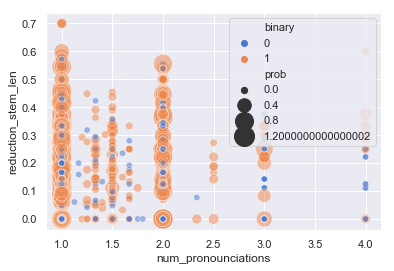

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = dataset_fc_linguistic[0].train
#data = data.loc[data.cal_ngram_2_sim_min>0.8,]

complexity_plot = sns.scatterplot(x="num_pronounciations", y="reduction_stem_len", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [39]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/len-to-port-stem-steps.pdf')

# (3.3) Corpus-Based Features
Here we compute features which are based on larger corpora. In this category we distinguish e.g. between frequency counts and N-Gram Language Model probabilites.

### (1) Frequency

In [47]:
from nltk.stem.wordnet import *
from collections import defaultdict
from wordmodel import Word
import pandas as pd

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

word_freq_wiki = {}
freq_sum_wiki = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        word_freq_wiki[word.strip()] = int(freq)
        freq_sum_wiki+=int(freq)
        
word_freq_simple_wiki = {}
freq_sum_simple_wiki = 0
with open("resources/word-freq-dumps/simple_wiki_word_freqs.txt", encoding="ISO-8859-1") as file:
    for line in file:
        word, freq = line.split()
        word_freq_simple_wiki[word.strip()] = int(freq)
        freq_sum_simple_wiki+=int(freq)
        
word_freq_lang8 = {}
freq_sum_lang8 = 0
with open("resources/word-freq-dumps/word_freqs_lang8.txt", encoding="ISO-8859-1") as file:
    for line in file:
        word, freq = line.split()
        word_freq_lang8[word.strip()] = int(freq)
        freq_sum_lang8+=int(freq)

word_freq_bnc = {}
with open("resources/word-freq-dumps/bnc_freq_all.al", encoding="utf8") as file:
    for line in file:
        freq, word, pos, num_files = line.split()
        word_freq_bnc[word.strip()] = (int(freq), pos, int(num_files))

word_freq_bnc_lemma = {}
with open("resources/word-freq-dumps/bnc_lemma.al", encoding="utf8") as file:
    for line in file:
        sort_order, frequency, word, word_class = line.split()
        word_freq_bnc_lemma[word.strip()] = (int(sort_order), word_class, int(frequency))

        
word_pknown_nobs_prev_freqZipf = {}
with open("resources/word-freq-dumps/word_prevelance.csv", encoding="utf8") as file:
    for line in file:
        word, p_known, nobs, prevelance, freqZipf = line.split(";")
        word_pknown_nobs_prev_freqZipf[word.strip()] = (float(p_known.replace(',','.')), 
                                                        float(nobs.replace(',','.')), 
                                                        float(prevelance.replace(',','.')), 
                                                        float(freqZipf.replace(',','.')))
        
subtlex_us = {}
with open("resources/dictionaries/SUBTLEXus.txt", encoding="utf8") as file:
    for line in file:
        word, freq, cd_count, freq_low, cd_low, subtl_wf, lg10_wf, Subtlcd, lg10_cd = line.split('\t')
        subtlex_us[word.strip().lower()] = (int(freq), int(cd_count))
        
subtlex_uk = pd.read_csv("resources/dictionaries/SUBTLEXuk.txt", sep = "\t")
subtlex_uk_dict = dict(zip(subtlex_uk['Spelling'], subtlex_uk['CD_count']))

def get_dict_count(target, freqs):
    return freqs.get(target.strip().lower(), 0)

def freqZipf(target):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[3] if stats else 3.5


WEIGHT_WIKI_SIMPLE_WIKI = freq_sum_wiki / freq_sum_simple_wiki
WEIGHT_WIKI_LANG_8 = freq_sum_wiki / freq_sum_lang8

def weighted_freq_ratio(target, word_freq_n, word_freq_m, weight):
    freq_n = word_freq_n.get(target.strip().lower(), 1)
    freq_m = word_freq_m.get(target.strip().lower(), 1)
    return -1 + (2 * (freq_n / ((freq_m * weight) + freq_n)))

C:\Users\Studio\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (11,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
mwe_targets_train = list(set([mwe for ds in datasets for mwe in ds.train['target'].tolist()]))
mwe_targets_test = list(set([mwe for ds in datasets for mwe in ds.test['target'].tolist()]))
mwe_targets = mwe_targets_train.copy()
mwe_targets.extend(mwe_targets_test)
print('Len ta_train : {}'.format(len(mwe_targets_train)))
print('Len ta_test : {}'.format(len(mwe_targets_test)))
print('Len targets : {}'.format(len(mwe_targets)))

In [49]:
import phrasefinder as pf

google_books_n_grams = {}
options = pf.SearchOptions()
options.topk = 10
n_grams = mwe_targets

with open('resources/word-freq-dumps/ngram_google.json', 'rb') as fp:
    google_books_n_grams = pickle.load(fp)

if not google_books_n_grams:
    for index, n_gram in enumerate(n_grams):
        try:
            print(index, n_gram)
            result = pf.search(pf.Corpus.AMERICAN_ENGLISH, n_gram, options)
            vals = [(phrase.match_count, phrase.volume_count, phrase.first_year, phrase.last_year)
                        for phrase in result.phrases]
            mean_vals = [np.sum(elem) / len(elem) for elem in zip(*vals)]
            google_books_n_grams[n_gram] = mean_vals
            if result.status != pf.Status.Ok:
                print('Request was not successful: {}'.format(result.status))
        except Exception as error:
            pass
    with open('resources/word-freq-dumps/ngram_google.json', 'wb') as fp:
        pickle.dump(google_books_n_grams, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [92]:
def features_frequency(dataframe, agg):   
    df = dataframe.copy()
    df['mrc_kf_freq'] = df.p_target.apply(lambda target : agg(target, mrc_database, \
                                                                    lambda word : word.kf_freq, 0))
    df['mrc_kf_ncats'] = df.p_target.apply(lambda target : agg(target, mrc_database, \
                                                                    lambda word : word.kf_ncats, 0))
    df['mrc_tl_freq'] = df.p_target.apply(lambda target : agg(target, mrc_database, \
                                                                    lambda word : word.tl_freq, 0))
    df['mrc_brown_freq'] = df.p_target.apply(lambda target : agg(target, mrc_database, \
                                                                    lambda word : word.brown_freq, 0))
    df['freq_wiki'] = df.p_target.apply(lambda target : agg(target, get_dict_count, word_freq_wiki))
    df['log_freq_wiki'] = df.freq_wiki.apply(lambda freq : np.nan_to_num(np.log(freq)))
    df['freq_simple_wiki'] = df.p_target.apply(lambda target : agg(target, get_dict_count, word_freq_simple_wiki))
    df['log_freq_simple_wiki'] = df.freq_simple_wiki.apply(lambda freq : np.nan_to_num(np.log(freq)))
    df['freq_bnc'] = df.p_target.apply(lambda target : agg(target, \
                                    lambda target : word_freq_bnc.get(target)[0] if word_freq_bnc.get(target) else 0))
    df['log_freq_bnc'] = df.freq_bnc.apply(lambda freq : np.nan_to_num(np.log(freq)))
    df['freq_bnc_lemma'] = df.p_lemma.apply(lambda target : agg(target, \
                    lambda target : word_freq_bnc_lemma.get(target)[2] \
                                         if word_freq_bnc_lemma.get(target) else 0))
    df['log_freq_bnc_lemma'] = df.freq_bnc_lemma.apply(lambda freq : np.nan_to_num(np.log(freq)))
    df['freqZipf'] = df.p_target.apply(lambda target : agg(target, freqZipf))
    df['google_books_n_gram_freq'] = df.p_target.apply(lambda target : google_books_n_grams.get(target)[0] \
                                                     if google_books_n_grams.get(target) else 0)
    df['log_google_books_n_gram_freq'] = df.google_books_n_gram_freq.apply(lambda freq : np.nan_to_num(np.log(freq)))
    df['google_books_n_gram_doc_freq'] = df.p_target.apply(lambda target : google_books_n_grams.get(target)[1] \
                                                        if google_books_n_grams.get(target)  else 0)
    df['log_google_books_n_gram_doc_freq'] = df.google_books_n_gram_doc_freq.apply(lambda freq : np.nan_to_num(np.log(freq)))
    df['google_books_n_gram_first_year'] = df.p_target.apply(lambda target : google_books_n_grams.get(target)[2] \
                                                          if google_books_n_grams.get(target)  else 0)
    df['google_books_n_gram_last_year'] = df.p_target.apply(lambda target : google_books_n_grams.get(target)[3] \
                                                         if google_books_n_grams.get(target)  else 0)
    df['subtlex_cd_us'] = df.p_target.apply(lambda target : agg_feat_num_average(target, \
                    lambda target : subtlex_us[target.strip().lower()][1] if subtlex_us.get(target.strip().lower()) else 0))
    df['subtlex_cd_uk'] = df.p_target.apply(lambda target : agg_feat_num_average(target, \
                                    lambda target : subtlex_uk_dict.get(target, 0)))
    df['weighted_wiki_simple_wiki_ratio'] = df.p_target.apply(lambda target : agg(target, \
                                    weighted_freq_ratio, word_freq_wiki, word_freq_simple_wiki, WEIGHT_WIKI_SIMPLE_WIKI))
    df['weighted_wiki_lang8_ratio'] = df.p_target.apply(lambda target : agg(target, \
                                    weighted_freq_ratio, word_freq_wiki, word_freq_lang8, WEIGHT_WIKI_SIMPLE_WIKI))
    df = df.fillna(0)
    return df

fc_frequency = FeatureCategory('frequency', features_frequency)
feature_categories.append(fc_frequency)

In [93]:
dataset_fc_frequency = [FeatureDataset(ds.name, fc_frequency, agg,
                fc_frequency.func(ds.train, agg.agg), fc_frequency.func(ds.test, agg.agg)) for ds in datasets
                          for agg in aggs]

### (2) Language Model
Here we load the different Kneser-Ney n-gram models we trained previously.

In [88]:
import pickle

with open('resources/language-models/ngram_char_1.json', 'rb') as fp:
    ngram_char_1 = pickle.load(fp)
    
with open('resources/language-models/ngram_word_1.json', 'rb') as fp:
    ngram_word_1 = pickle.load(fp)

with open('resources/language-models/ngram_char_2.json', 'rb') as fp:
    ngram_char_2 = pickle.load(fp)
    
with open('resources/language-models/ngram_word_2.json', 'rb') as fp:
    ngram_word_2 = pickle.load(fp)
    
with open('resources/language-models/ngram_char_3.json', 'rb') as fp:
    ngram_char_3 = pickle.load(fp)
    
with open('resources/language-models/ngram_char_2_complex.json', 'rb') as fp:
    ngram_char_2_complex = pickle.load(fp)
    
with open('resources/language-models/ngram_char_2_non_complex.json', 'rb') as fp:
    ngram_char_2_non_complex = pickle.load(fp)
    
with open('resources/language-models/ngram_char_2_complex_cleaned.json', 'rb') as fp:
    ngram_char_2_complex_cleaned = pickle.load(fp)
    
with open('resources/language-models/ngram_char_2_non_complex_cleaned.json', 'rb') as fp:
    ngram_char_2_non_complex_cleaned = pickle.load(fp)
    
def kneser_ney_word_uni_gram(target):
    return ngram_word_1.cond_prob(target)

def kneser_ney_word_bi_gram(target):
    words = target.split()
    if len(words) <= 1:
        return ngram_word_2.cond_prob(target)
    return np.mean([ngram_word_2.cond_prob(words[index+1], (word,)) 
                for index, word in enumerate(words) 
                if index <= len(words)-2])
    
def kneser_ney_char_uni_gram_avg(target):
    return np.mean([ngram_char_1.cond_prob(character) 
            for character in target])

def kneser_ney_char_bi_gram_avg(target):
    return np.mean([ngram_char_2.cond_prob(target[index+1], (character,)) 
            for index, character in enumerate(target) if index <= len(target)-2])

def kneser_ney_char_bi_gram_avg_model(target, kn_model):
    return np.mean([kn_model.cond_prob(target[index+1], (character,)) 
            for index, character in enumerate(target) if index <= len(target)-2])

def kneser_ney_char_tri_gram_avg(target):
    return np.mean([ngram_char_3.cond_prob(target[index+2], (character, target[index+1])) 
            for index, character in enumerate(target) if index <= len(target)-3])

In [95]:
from nltk.stem.wordnet import *
wordNetLemmatizer = WordNetLemmatizer()

def features_language_model(dataframe, agg):
    df = dataframe.copy()
    df['kneser_ney_word_uni_gram'] = df.target.apply(lambda target : agg(target, \
                                                    kneser_ney_word_uni_gram))
    df['kneser_ney_word_bi_gram'] = df.target.apply(lambda target :  kneser_ney_word_bi_gram(target))
    df['kneser_ney_char_uni_gram_avg'] = df.target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_uni_gram_avg))
    df['kneser_ney_char_bi_gram_avg'] = df.target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg))
    df['kneser_ney_char_tri_gram_avg'] = df.target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_tri_gram_avg))
    df['kneser_ney_char_bi_complex'] = df.target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg_model, ngram_char_2_complex))
    df['kneser_ney_char_bi_non_complex'] = df.target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg_model, ngram_char_2_non_complex))
    df['kneser_ney_char_bi_c_nc_ratio'] = df.kneser_ney_char_bi_complex / df.kneser_ney_char_bi_non_complex
    df['kneser_ney_char_bi_complex_cl'] = df.target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg_model, ngram_char_2_complex_cleaned))
    df['kneser_ney_char_bi_non_complex_cl'] = df.target.apply(lambda target : agg(target, \
                                                    kneser_ney_char_bi_gram_avg_model, ngram_char_2_non_complex_cleaned))
    df['kneser_ney_char_bi_c_nc_ratio_cl'] = df.kneser_ney_char_bi_complex_cl / df.kneser_ney_char_bi_non_complex_cl
    df = df.fillna(0)
    return df

fc_language_model = FeatureCategory('language_model', features_language_model)
feature_categories.append(fc_language_model)

In [96]:
dataset_fc_language_model = [FeatureDataset(ds.name, fc_language_model, agg,
                fc_language_model.func(ds.train, agg.agg), fc_language_model.func(ds.test, agg.agg)) for ds in datasets
                          for agg in aggs]

C:\Users\Studio\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [109]:
fc_corpus = FeatureCategory('corpus', [fc_frequency, fc_language_model])
dataset_fc_corpus = [FeatureDataset(ds.name, fc_corpus,  ds.agg,
            ds.train, ds.test) for ds in concat_feature_datasets(dataset_fc_frequency, dataset_fc_language_model)]

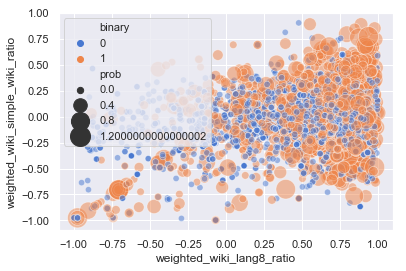

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = dataset_fc_corpus[0].train
data = data.loc[data.kneser_ney_char_bi_c_nc_ratio_cl<1.2,]
#data['kneser20'] = data.kneser_ney_word_uni_gram * 10000
#data = data.loc[data.kneser20<10,]
complexity_plot_1 = sns.scatterplot(x="weighted_wiki_lang8_ratio", y="weighted_wiki_simple_wiki_ratio", 
                                    hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot_1)

In [83]:
figure = complexity_plot_1.get_figure()
figure.savefig('../plots/features/weighted-wiki-to-kn-bi-c-nc-cl.pdf')

C:\Users\Studio\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


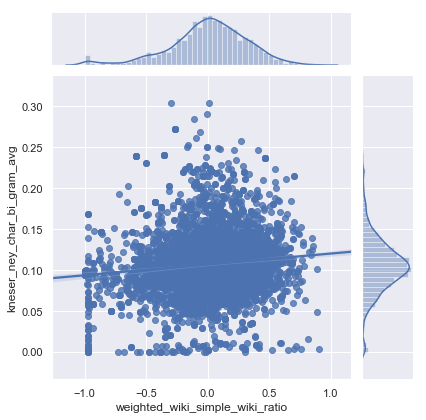

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = dataset_fc_corpus[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.jointplot(x="weighted_wiki_simple_wiki_ratio", y="kneser_ney_char_bi_gram_avg", data=data, kind="reg")
plt.show(complexity_plot)

In [118]:
concat_features = concat_feature_datasets(dataset_fc_linguistic, dataset_fc_corpus)

C:\Users\Studio\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


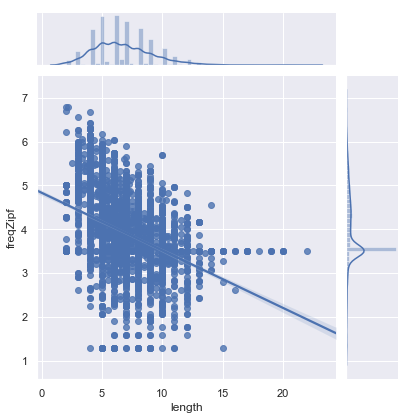

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.jointplot(x="length", y="freqZipf", data=data, kind="reg")
plt.show(complexity_plot)

# (3.4) Psycholinguistic Features based on MRC Database


In [122]:
from wordmodel import Word

words_mrc_database = {}
with open("resources/mrc-database/mrc2.dct", encoding="utf8") as file:
    for index, line in enumerate(file):
        line = line.strip()
        word, phon, dphon, stress = line[51:].split('|')
        w = Word(
                wid = index,
                nlet = int(line[0:2]),
                nphon = int(line[2:4]),
                nsyl = int(line[4]),
                kf_freq = int(line[5:10]),
                kf_ncats = int(line[10:12]),
                kf_nsamp = int(line[12:15]),
                tl_freq = int(line[15:21]),
                brown_freq = int(line[21:25]),
                fam = int(line[25:28]),
                conc = int(line[28:31]),
                imag = int(line[31:34]),
                meanc = int(line[34:37]),
                meanp = int(line[37:40]),
                aoa = int(line[40:43]),
                tq2 = line[43],
                wtype = line[44],
                pdwtype = line[45],
                alphasyl = line[46],
                status = line[47],
                var = line[48],
                cap = line[49],
                irreg = line[50],
                word=word,
                phon=phon,
                dphon=dphon,
                stress=stress)
        words_mrc_database[w.word.strip().lower()] = w

def mrc_database(target, func, missing_val):
    word = words_mrc_database.get(target.strip().lower())
    val = func(word) if word else missing_val
    return val if val != 0 else missing_val

word_concreteness = {}
with open("resources/word-freq-dumps/concreteness_brysbaert_et_al.txt", encoding="utf8") as file:
    for line in file:
        word, bigram, conc_m, conc_sd, \
        unknown, total, percent_known, \
        subtlex, dom_pos = line.split('\t')
        word_concreteness[word.strip()] = float(conc_m)
        
word_age_of_aquisition = {}
with open("resources/word-freq-dumps/AoA_ratings_Kuperman_et_al_BRM.csv", encoding="utf8") as file:
    for line in file:
        word, occur_total, occur_num, freq_pm, rating_Mean, rating_SD, dunno = line.split()
        word_age_of_aquisition[word.strip()] = float(rating_Mean.replace(',', '.')) if rating_Mean != 'NA' else 0

word_pknown_nobs_prev_freqZipf = {}
with open("resources/word-freq-dumps/word_prevelance.csv", encoding="utf8") as file:
    for line in file:
        word, p_known, nobs, prevelance, freqZipf = line.split(";")
        word_pknown_nobs_prev_freqZipf[word.strip()] = (float(p_known.replace(',','.')), 
                                                        float(nobs.replace(',','.')), 
                                                        float(prevelance.replace(',','.')), 
                                                        float(freqZipf.replace(',','.')))

def perc_known(target, missing_value):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[0] if stats else missing_value

def nobs(target):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[1] if stats else 0

def prevelance(target):
    stats = word_pknown_nobs_prev_freqZipf.get(target)
    return stats[2] if stats else 0

In [123]:
def features_psycholingusitic(dataframe, agg):
    df = dataframe.copy()
    df['mrc_fam'] = df.target.apply(lambda target : agg(target, mrc_database, lambda word : word.fam, 400))
    df['mrc_conc'] = df.target.apply(lambda target : agg(target, mrc_database, lambda word : word.conc, 400))
    df['mrc_imag'] = df.target.apply(lambda target : agg(target, mrc_database, lambda word : word.imag, 400))
    df['mrc_meanc'] = df.target.apply(lambda target : agg(target, mrc_database, lambda word : word.meanc, 400))
    df['mrc_meanp'] = df.target.apply(lambda target : agg(target, mrc_database, lambda word : word.meanp, 400))
    df['mrc_aoa'] = df.target.apply(lambda target : agg(target, mrc_database, lambda word : word.aoa, 3.5))
    df['perc_known'] = df.target.apply(lambda target : agg(target, perc_known, 0.5))
    df['nobs'] = df.target.apply(lambda target : agg(target, nobs))
    df['prevelance'] = df.target.apply(lambda target : agg(target, prevelance))
    df['concreteness'] = df.target.apply(lambda target : agg(target, \
                                                lambda target : word_concreteness.get(target, 2.5)))
    df['age_of_aquisition'] = df.target.apply(lambda target : agg(target, \
                                                    lambda target : word_age_of_aquisition.get(target, 8.5)))
    df = df.fillna(0)
    return df

fc_psycholinguistic = FeatureCategory('psycholinguistic', features_psycholingusitic)
feature_categories.append(fc_psycholinguistic)

In [124]:
dataset_fc_psycholinguistic = [FeatureDataset(ds.name, fc_psycholinguistic, agg,
                fc_psycholinguistic.func(ds.train, agg.agg), fc_psycholinguistic.func(ds.test, agg.agg)) for ds in datasets
                    for agg in aggs]

In [125]:
concat_features = concat_feature_datasets(dataset_fc_psycholinguistic, dataset_fc_linguistic)

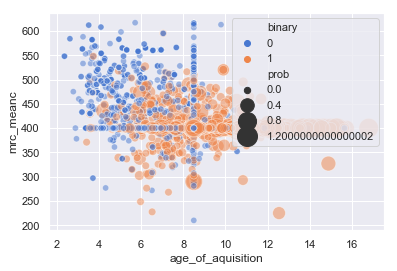

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="age_of_aquisition", y="mrc_meanc", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [48]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/aoa-mrc_meanc.pdf')

# (3.5) Semantic Features
Here we implement all the relevant features based on WordNet and SentiWordNet. For example, the number of synsets the target word is contained in or the average length of the lemmas of all the synsets the target word is contained in. Note that all features that are computed in the following exploit neither the POS-Tag of the target word nor Word Sense Disambiguation by e.g. UKB-Algorithm.

### (3.5.1) WordNet

In [149]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
from nltk.stem.wordnet import *
from utils import penn_to_wn

wordNetLemmatizer = WordNetLemmatizer()

def wn_synset_freq(target):
    return len(wn.synsets(target))

def wn_synset_avg_lemma_freq(target):
    return np.nan_to_num(np.mean([len(synset.lemmas()) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_lemma_len(target):
    return np.nan_to_num(np.nanmean([len(lemma.name()) 
            for synset in wn.synsets(target) 
            for lemma in synset.lemmas()]))

def wn_synset_avg_hypernyms(target):
    return np.nan_to_num(np.nanmean([len(synset.hypernyms()) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_hyponyms(target):
    return np.nan_to_num(np.mean([len(synset.hyponyms()) 
            for synset in wn.synsets(target)]))

def wn_synset_sum_hypernyms(target):
    return np.sum(([len(synset.hypernyms()) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_definition_len(target):
    return np.nan_to_num(np.mean([len(str(synset.definition())) 
            for synset in wn.synsets(target)]))

def wn_synset_avg_hyptree_depth(target):
    return np.nan_to_num(np.mean([synset.max_depth() 
            for synset in wn.synsets(target)]))

def wn_synset_num_distinct_pos(target):
    return len(set([synset.pos() for synset in wn.synsets(target)]))

def wn_synset_avg_num_relations(target):
    return np.nan_to_num(np.mean([np.sum([len(synset.hypernyms()), len(synset.hyponyms()), 
             len(synset.instance_hypernyms()), len(synset.instance_hyponyms()),
             len(synset.member_holonyms()), len(synset.substance_holonyms()),
             len(synset.part_holonyms()), len(synset.member_meronyms()),
             len(synset.substance_meronyms()), len(synset.part_meronyms())]) 
             for synset in wn.synsets(target)]))

def wn_synset_avg_freq_pos(target, pos):
    return len(wn.synsets(target, pos = pos))

def wn_synset_pos_ratio_1(target, pos):
    synsets_freqs = len(wn.synsets(target))
    return len(wn.synsets(target, pos = pos)) / synsets_freqs \
            if synsets_freqs != 0 else 0.25

def wn_synset_pos_ratio_2(target, pos):
    synsets_counts = np.sum([lemma.count() 
            for sn in wn.synsets(target) for lemma in sn.lemmas()])
    return np.sum([lemma.count() for sn in wn.synsets(target, pos = pos) 
                for lemma in sn.lemmas()]) / synsets_counts if synsets_counts != 0 else 0.25 

def wn_synset_sense_entropy_uniform(target):
    num_senses = len(wn.synsets(target))
    return -np.sum([((1 / num_senses) * np.log2(1 / num_senses)) 
                     for index in range(0, num_senses)])

def wn_synset_sense_entropy_pos_uniform(target):
    num_senses = len(wn.synsets(target))
    pos_distribution = [len(wn.synsets(target, pos = wn.NOUN)),
                        len(wn.synsets(target, pos = wn.VERB)),
                        len(wn.synsets(target, pos = wn.ADJ)),
                        len(wn.synsets(target, pos = wn.ADV))]
    return -np.sum([(np.nan_to_num((count / num_senses) * np.log2(count / num_senses))) 
            for count in pos_distribution]) if num_senses != 0 else 0

def wn_synsets_sense_entropy_pos_central(target, pos):
    num_senses_pos = len(wn.synsets(target, pos = pos))
    return -np.sum([((1 / num_senses_pos) * np.log2(1 / num_senses_pos))
                     for index in range(0, num_senses_pos)])

def wn_synset_pos_probability_1(target, pos):
    synsets = wn.synsets(target)
    syn_freq_other_pos = np.sum([1 for synset in synsets if synset.pos() != pos])
    return len(wn.synsets(target, pos = pos)) / syn_freq_other_pos

def wn_synsets_avg_lemma_freq(target, freqs_func, freqs):
    synsets = wn.synsets(target)
    if not synsets:
        return 0
    return np.mean([np.nan_to_num(freqs_func(lemma.name(), freqs)) for synset in synsets
                    for lemma in synset.lemmas()])

def wn_synsets_freq_ratio_to_max_agg_min(target, freqs_func, freqs):
    lemmas = [lemma.name().split('_') for synset in wn.synsets(target) 
                  for lemma in synset.lemmas()]
    if not lemmas:
        return 1
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata]) 
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    if target_freq not in freqis: freqis.append(target_freq)
    max_freq = np.max(freqis)
    return target_freq / max_freq

def wn_synsets_freq_ratio_to_max_agg_mean(target, freqs_func, freqs):
    lemmas = [lemma.name().split('_') for synset in wn.synsets(target) 
                  for lemma in synset.lemmas()]
    if not lemmas:
        return 1
    freqis = [np.mean([freqs_func(lemma, freqs) for lemma in lemmata]) 
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    if target_freq not in freqis: freqis.append(target_freq)
    max_freq = np.max(freqis)
    return target_freq / max_freq

def wn_synsets_freq_ratio_to_max_agg_median(target, freqs_func, freqs):
    lemmas = [lemma.name().split('_') for synset in wn.synsets(target) 
                  for lemma in synset.lemmas()]
    if not lemmas:
        return 1
    freqis = [np.median([freqs_func(lemma, freqs) for lemma in lemmata]) 
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    if target_freq not in freqis: freqis.append(target_freq)
    max_freq = np.max(freqis)
    return target_freq / max_freq
    
def swn_avg_objective_score(target):
    return np.nan_to_num(np.mean([senti_synset.obj_score() 
                for senti_synset in swn.senti_synsets(target)]))


@lru_cache(maxsize=None)
def wordnet_pos_tagging(tokens):
    return nltk.pos_tag(tokens)

def pos_tag(sentence, target):
    tokens = nltk.word_tokenize(sentence)
    wordPOSPairs = [token for token in wordnet_pos_tagging(tokens) if token[0] == target]
    return wordPOSPairs[0][1] if len(wordPOSPairs) > 0 else None

def wordnet_lemma_len(target):
    return len(wordNetLemmatizer.lemmatize(target))

def wn_synset_lesk_wsd_ratio_hi_freq(target, sentence, pos, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq > target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_hi_freq_sum(target, sentence, pos, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([freq for freq in freqis if freq > target_freq]) / np.sum(freqis)

def wn_synset_lesk_wsd_ratio_hi_nopos_freq(target, sentence, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq > target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_low_freq(target, sentence, pos, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq < target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_low_freq_sum(target, sentence, pos, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([freq for freq in freqis if freq < target_freq]) / np.sum(freqis)

def wn_synset_lesk_wsd_ratio_low_nopos_freq(target, sentence, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return np.sum([1 for freq in freqis if freq < target_freq]) / len(freqis)

def wn_synset_lesk_wsd_ratio_to_freq_sum(target, sentence, pos, freqs_func, freqs):
    wsd_synset = lesk(sentence.split(), target, pos)
    if not wsd_synset:
        return 0
    lemmas = [lemma.name().split('_') for lemma in wsd_synset.lemmas()]
    if not lemmas:
        return 0
    freqis = [np.min([freqs_func(lemma, freqs) for lemma in lemmata])
              for lemmata in lemmas]
    target_freq = freqs_func(target, freqs)
    return target_freq / np.sum(freqis)

#TODO implement with other wsd algorithm and lemma count
#Implement wsd algorithm based on word embeddings and also use pywsd
def wn_synset_lesk_wsd__norm_sense_rank(target, sentence, pos, freqs_func, freqs, wsd_func):
    wsd_synset = wsd_func(sentence.split(), target, pos)
    senses = wn.synsets(target)
    if not wsd_synset:
        return 0
    wsd_synset = lesk(sentence.split(), target, pos)
    sense_freqs = sorted([(sense, np.sum([lemma.count() for lemma in sense.lemmas()])) 
                   for sense in senses], key = lambda tpl : tpl[1], reverse=True)
    sense_index = [sense for sense, cnt in sense_freqs].index(wsd_synset)
    return sense_index / len(senses)

In [150]:
from nltk.wsd import lesk
from pywsd.lesk import adapted_lesk

def features_wordnet(dataframe, agg):
    df = dataframe.copy()
    df['wn_synset_freq'] = df.target.apply(lambda target : agg(target, wn_synset_freq))
    df['wn_synset_avg_lemma_freq'] = df.target.apply(lambda target : agg(target, wn_synset_avg_lemma_freq))
    df['wn_synset_avg_lemma_len'] = df.target.apply(lambda target : agg(target, wn_synset_avg_lemma_len))
    
    df['length'] = df.target.apply(lambda target : agg(target, len))
    df['wn_synset_diff_len_avg_lemma_len'] = df.wn_synset_avg_lemma_len - df.length
    df['wn_synset_avg_hypernyms'] = df.target.apply(lambda target : agg(target, wn_synset_avg_hypernyms))
    df['wn_synset_sum_hypernyms'] = df.target.apply(lambda target : agg(target, wn_synset_sum_hypernyms))
    df['wn_synset_avg_hyponyms'] = df.target.apply(lambda target : agg(target, wn_synset_avg_hyponyms))

    df['wn_synset_avg_definition_len'] = df.target.apply(lambda target : 
                                                         agg(target, wn_synset_avg_definition_len))
    df['wn_synset_avg_hyptree_depth'] = df.target.apply(lambda target :
                                                         agg(target, wn_synset_avg_hyptree_depth))
    df['wn_synset_num_distinct_pos'] = df.target.apply(lambda target : 
                                                         agg(target, wn_synset_num_distinct_pos))
    df['wn_synset_avg_num_relations'] = df.target.apply(lambda target : 
                                                         agg(target, wn_synset_avg_num_relations))

    df['wn_synset_avg_freq_pos_noun'] = df.target.apply(lambda target : 
                                                        agg(target, wn_synset_avg_freq_pos, wn.NOUN))
    df['wn_synset_avg_freq_pos_verb'] = df.target.apply(lambda target : 
                                                        agg(target, wn_synset_avg_freq_pos, wn.VERB))
    df['wn_synset_avg_freq_pos_adj'] = df.target.apply(lambda target : 
                                                       agg(target, wn_synset_avg_freq_pos, wn.ADJ))
    df['wn_synset_avg_freq_pos_adv'] = df.target.apply(lambda target : 
                                                       agg(target, wn_synset_avg_freq_pos, wn.ADV))

    df['wn_synset_avg_freq_pos_noun_norm'] = np.nan_to_num(df.wn_synset_avg_freq_pos_noun / df.wn_synset_freq)
    df['wn_synset_avg_freq_pos_verb_norm'] = np.nan_to_num(df.wn_synset_avg_freq_pos_verb / df.wn_synset_freq)
    df['wn_synset_avg_freq_pos_adj_norm'] = np.nan_to_num(df.wn_synset_avg_freq_pos_adj / df.wn_synset_freq)
    df['wn_synset_avg_freq_pos_adv_norm'] = np.nan_to_num(df.wn_synset_avg_freq_pos_adv / df.wn_synset_freq)

    df['pos_tag'] = df[['sentence', 'target']].apply(lambda vals : pos_tag(*vals), axis = 1)
    df['wn_synset_sense_entropy_uniform'] = df.target.apply(lambda target : 
                                            agg(target, wn_synset_sense_entropy_uniform))
    df['wn_synset_sense_entropy_pos_uniform'] = df.target.apply(lambda target :
                                            agg(target, wn_synset_sense_entropy_pos_uniform))
    df['wn_synsets_sense_entropy_pos_central'] = df[['target', 'pos_tag']].apply(
        lambda vals : wn_synsets_sense_entropy_pos_central(vals[0], penn_to_wn(vals[1])), axis = 1)
    
    df['wn_synset_pos_ratio_1'] = df[['target', 'pos_tag']].apply(
                    lambda vals : wn_synset_pos_ratio_1(vals[0], penn_to_wn(vals[1])), axis = 1)
    
    df['wn_synset_pos_ratio_2'] = df[['target', 'pos_tag']].apply(
                    lambda vals : wn_synset_pos_ratio_2(vals[0], penn_to_wn(vals[1])), axis = 1)

    df['swn_avg_objective_score'] = df.target.apply(lambda target : agg(target, swn_avg_objective_score))

    df['wn_synsets_freq_ratio_to_max_agg_min'] = df.target.apply(lambda target : \
                                                    agg(target, wn_synsets_freq_ratio_to_max_agg_min, \
                                                                         get_dict_count, word_freq_wiki))
    df['wn_synsets_freq_ratio_to_max_agg_mean'] = df.target.apply(lambda target : \
                                                    agg(target, wn_synsets_freq_ratio_to_max_agg_mean, \
                                                                         get_dict_count, word_freq_wiki))
    df['wn_synsets_freq_ratio_to_max_agg_median'] = df.target.apply(lambda target : \
                                                    agg(target, wn_synsets_freq_ratio_to_max_agg_median, \
                                                                         get_dict_count, word_freq_wiki))
    df['wn_synsets_avg_lemma_freq'] = df.target.apply(lambda target : \
                                                    agg(target, wn_synsets_avg_lemma_freq, \
                                                                         get_dict_count, word_freq_wiki))
    df['freq_wiki'] = df.target.apply(lambda target : agg(target, get_dict_count, word_freq_wiki))
    df['wn_synsets_freq_ratio_to_avg'] = df.wn_synsets_avg_lemma_freq / df.freq_wiki
    df['wn_synset_lesk_wsd_ratio_hi_freq'] = df[['target','sentence', 'pos_tag']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_hi_freq, vals[1], vals[2], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_low_freq'] = df[['target','sentence', 'pos_tag']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_low_freq, vals[1], vals[2], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_hi_nopos_freq'] = df[['target','sentence']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_hi_nopos_freq, vals[1], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_low_nopos_freq'] = df[['target','sentence']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_low_nopos_freq, vals[1], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_hi_freq_sum'] = df[['target','sentence', 'pos_tag']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_hi_freq_sum, vals[1], vals[2], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_low_freq_sum'] = df[['target','sentence', 'pos_tag']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_low_freq_sum, vals[1], vals[2], \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd_ratio_to_freq_sum'] = df[['target','sentence', 'pos_tag']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd_ratio_to_freq_sum, vals[1], penn_to_wn(vals[2]), \
                                     get_dict_count, word_freq_wiki), axis = 1)
    df['wn_synset_lesk_wsd__norm_sense_rank'] = df[['target','sentence', 'pos_tag']].apply(lambda vals : \
                agg(vals[0], wn_synset_lesk_wsd__norm_sense_rank, vals[1], penn_to_wn(vals[2]), \
                                     get_dict_count, word_freq_wiki, lesk), axis = 1)
    df = df.drop(['length', 'freq_wiki'], axis = 1)
    #df = df.fillna(0)
    return df

fc_wordnet = FeatureCategory('wordnet', features_wordnet)
feature_categories.append(fc_wordnet)

In [151]:
dataset_fc_wordnet = [FeatureDataset(ds.name, fc_wordnet, agg,
                fc_wordnet.func(ds.train, agg.agg), fc_wordnet.func(ds.test, agg.agg)) for ds in datasets
                      for agg in aggs]

C:\Users\Studio\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: Mean of empty slice
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: Mean of empty slice


TypeError: ("unhashable type: 'list'", 'occurred at index 0')

In [ ]:
train = dataset_fc_semantic[1].train
train.loc[train.target=='cut',['target', 'sentence', 'wn_synset_pos_ratio_1', 'wn_synset_pos_ratio_2']]

In [ ]:
concat_features = concat_feature_datasets(dataset_fc_semantic, dataset_fc_orthographic,
                                          dataset_fc_psycholinguistic)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="wn_synset_pos_ratio_2", y="wn_synset_freq", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [ ]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/syn-freq-to-avg-def-len.pdf')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.jointplot(x="wn_synset_avg_hyptree_depth", y="concreteness", data=data, kind="reg")
plt.show(complexity_plot)

In [ ]:
complexity_plot.savefig('../plots/features/wn-hyp-depth-to-conc.pdf')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.lmplot(x="wn_synset_avg_hyptree_depth", y="concreteness", hue='binary', data=data)
plt.show(complexity_plot)

In [ ]:
complexity_plot.savefig('../plots/features/wn-hyp-depth-to-conc-2.pdf')

### (3.5.2) DBpedia

In [34]:
import spotlight
from joblib import Memory

memory = Memory(location='resources/dbpedia-cache', verbose=0)
@memory.cache
def annotate_dbpedia_spotlight(sentence, confidence=0.0, support=20):
    return spotlight.annotate('https://api.dbpedia-spotlight.org/en/annotate',
                                sentence, confidence=confidence, support=support)

In [35]:
sentences_train = list(set([sentence for ds in datasets for sentence in ds.train['sentence'].unique().tolist()]))
sentences_test = list(set([sentence for ds in datasets for sentence in ds.test['sentence'].unique().tolist()]))
sentences = sentences_train.copy()
sentences.extend(sentences_test)
print('Len ta_train : {}'.format(len(sentences_train)))
print('Len ta_test : {}'.format(len(sentences_test)))
print('Len targets : {}'.format(len(sentences)))

Len ta_train : 1988
Len ta_test : 266
Len targets : 2254


In [ ]:
import time

sents_dbpedia_75 = {}
sent_no_annotation = []
for index, sentence in enumerate(sentences):
    print('{} : {}'.format(index, sentence))
    if(index % 100 == 0):
        print('----------Sleeping----------')
        time.sleep(60)
    try:
        sents_dbpedia_75[sentence] = annotate_dbpedia_spotlight(sentence, confidence = 0.75)
    except:
        sent_no_annotation.append(sentence)

In [52]:
import pickle

with open('resources/dbpedia-cache/dbpedia_annotations_00.json', 'rb') as fp:
    dbpedia_00 = pickle.load(fp)
    
with open('resources/dbpedia-cache/dbpedia_annotations_25.json', 'rb') as fp:
    dbpedia_25 = pickle.load(fp)
    
with open('resources/dbpedia-cache/dbpedia_annotations_50.json', 'rb') as fp:
    dbpedia_50 = pickle.load(fp)
    
with open('resources/dbpedia-cache/dbpedia_annotations_75.json', 'rb') as fp:
    dbpedia_75 = pickle.load(fp)
    
with open('resources/dbpedia-cache/pagerank.json', 'rb') as fp:
        page_rank = pickle.load(fp)

In [43]:
uris = list(set([an['URI'] for sentence, lst in dbpedia_00.items() for an in lst]))

In [44]:
len(uris)

5633

In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON
import time

exceptions = []
page_rank = {}
for index, uri in enumerate(uris):
    try:
        print('{} : {}'.format(index, uri))
        if(index % 200 == 0):
            print('----------Sleeping----------')
            time.sleep(60)
        sparql = SPARQLWrapper("http://dbpedia.org/sparql")
        sparql.setQuery("""
            PREFIX rdf:<http://www.w3.org/1999/02/22-rdf-syntax-ns#>
            PREFIX vrank:<http://purl.org/voc/vrank#>
            PREFIX dbo:<http://dbpedia.org/ontology/>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            SELECT distinct ?v
            FROM <http://dbpedia.org>
            FROM <http://people.aifb.kit.edu/ath/#DBpedia_PageRank>
            WHERE {
                <"""+ uri +"""> vrank:hasRank/vrank:rankValue ?v.
            }
        """)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        for result in results["results"]["bindings"]:
            page_rank[uri] = float(result['v']['value'])
    except Exception as e:
        exceptions.append(str(e))

In [137]:
def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def dbp_match_entities(sentence, target, start, end, annotations):
    an_sents = annotations.get(sentence)
    if an_sents:
        ans = [(an['offset'], an['offset']+len(an['surfaceForm']), an) for an in an_sents]
        return [an for s, e, an in ans if overlaps(start, end, s, e)]
    return []

def dbp_entity_ratio(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if entities:
        return np.min([np.sum([len(entity['surfaceForm']) 
                for entity in entities]) / len(target), 1])
    return 0

def dbp_support(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if entities:
        return np.mean([entity['support'] for entity in entities])
    return 0

def dbp_type_hierachy_depth(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if entities:
        return np.mean([np.sum([1 for cat in entity['types'].split(',') if 'DBpedia' in cat])
                 for entity in entities])
    return 0

def dbp_freq_types(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if entities:
        return np.mean([len(entity['types'].split(',')) for entity in entities])
    return 0

def dbp_confidence(sentence, target, start, end):
    entities = dbp_match_entities(sentence, target, start, end, dbpedia_75)
    if entities:
        return 0.75
    entities = dbp_match_entities(sentence, target, start, end, dbpedia_50)
    if entities:
        return 0.5
    entities = dbp_match_entities(sentence, target, start, end, dbpedia_25)
    if entities:
        return 0.25
    return 0

def dbp_pagerank(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    return np.nan_to_num(np.mean([page_rank.get(entity['URI'], 0) for entity in entities]))

dbp_types = [('DBpedia:Place', 1, 'dbo:Place'), ('DBpedia:Person',2, 'dbo:Person'), 
             ('DBpedia:Organisation',3, 'dbo:Organisation'), ('DBpedia:Timeperiod', 4, 'dbo:Timeperiod')]

def dbp_extract_type(entity):
    types = [(cat, rank, name) for cat, rank, name in dbp_types if cat in entity['types']]
    if not types and not entity['types']:
        return ('dbo:notype', 0, 'dbo:notype')
    if not types and entity['types']:
        return ('dbo:misc', 5, 'dbo:misc')
    else:
        return types[0]

def dbp_type(sentence, target, start, end, annotations):
    entities = dbp_match_entities(sentence, target, start, end, annotations)
    if not entities:
        return 'dbo:notype'
    types = [dbp_extract_type(entity) for entity in entities]
    sorted(types, key=lambda tpl : tpl[1])
    return types[0][2]

In [138]:
train = datasets[0].train
df_tester = train.loc[train.sentence==sentences[2],]

def features_dbpedia(dataframe, agg):
    df = dataframe.copy()
    df['dbp_entity_ratio_25'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_entity_ratio(*vals, dbpedia_25),axis = 1)
    df['dbp_entity_support_25'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_support(*vals, dbpedia_25),axis = 1)
    df['dbp_type_hierachy_depth_25'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_type_hierachy_depth(*vals, dbpedia_25),axis = 1)
    df['dbp_freq_types_25'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_freq_types(*vals, dbpedia_25),axis = 1)
    df['dbp_confidence'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_confidence(*vals),axis = 1)
    df['dbp_pagerank'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_pagerank(*vals, dbpedia_25),axis = 1)
    max_page_rank = np.max(df.dbp_pagerank)
    df['dbp_norm_pagerank'] = df.dbp_pagerank / max_page_rank
    df['dbp_type'] = df[['sentence', 'target', 'start', 'end']].apply(lambda vals :
                                                          dbp_type(*vals, dbpedia_25),axis = 1)
    df = df.fillna(0)
    return df

fc_dbpedia = FeatureCategory('dbpedia', features_dbpedia)
feature_categories.append(fc_dbpedia)

In [139]:
dataset_fc_dbpedia = [FeatureDataset(ds.name, fc_dbpedia, agg,
                fc_dbpedia.func(ds.train, agg.agg), fc_dbpedia.func(ds.test, agg.agg)) for ds in datasets
                     for agg in aggs]

C:\Users\Studio\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Studio\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [112]:
dataset_fc_dbpedia[0].train

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,prob,dbp_entity_ratio_25,dbp_entity_support_25,dbp_type_hierachy_depth_25,dbp_freq_types_25,dbp_confidence,dbp_pagerank,dbp_norm_pagerank,dbp_type
0,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",0,8,Normally,10,10,0,1,1,0.05,0.000000,0.0,0.0,0.0,0.00,0.00000,0.000000,dbo:notype
1,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",28,34,passed,10,10,0,1,1,0.05,0.000000,0.0,0.0,0.0,0.00,0.00000,0.000000,dbo:notype
2,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",15,19,land,10,10,0,0,0,0.00,1.000000,3090.0,0.0,1.0,0.50,49.21810,0.004448,dbo:notype
3,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",43,49,future,10,10,1,0,1,0.05,1.000000,1406.0,0.0,1.0,0.50,15.85600,0.001433,dbo:notype
4,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",43,61,future generations,10,10,1,2,1,0.15,0.944444,1200.0,0.0,1.0,0.50,19.60765,0.001772,dbo:notype
5,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",50,61,generations,10,10,3,2,1,0.25,1.000000,994.0,0.0,1.0,0.50,23.35930,0.002111,dbo:notype
6,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",76,86,recognizes,10,10,2,4,1,0.30,1.000000,654.0,0.0,1.0,0.50,57.22910,0.005171,dbo:notype
7,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",91,100,community,10,10,0,0,0,0.00,0.000000,0.0,0.0,0.0,0.00,0.00000,0.000000,dbo:notype
8,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",104,115,traditional,10,10,1,3,1,0.20,1.000000,2642.0,0.0,1.0,0.50,69.92850,0.006319,dbo:notype
9,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",104,142,traditional connection to that country,10,10,0,0,0,0.00,0.552632,1416.0,0.0,1.0,0.50,36.98442,0.003342,dbo:notype


In [142]:
concat_features = concat_feature_datasets(dataset_fc_dbpedia, dataset_fc_orthographic,
                                          dataset_fc_psycholinguistic)

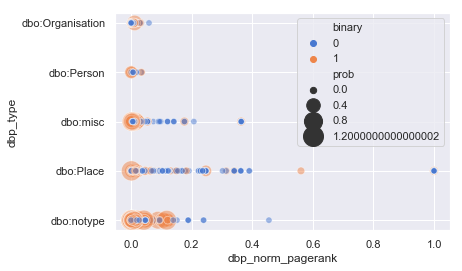

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[0].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="dbp_norm_pagerank", y="dbp_type", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
complexity_plot.legend(scatterpoints=1)
plt.show(complexity_plot)

In [120]:
figure = complexity_plot.get_figure()
figure.savefig('../plots/features/dbp-rank-to-freq-types.pdf')

## (3.5.3) Brown Clustering

In [ ]:
brown_cluster_word2cluster = {}
brown_cluster_cluster2words = defaultdict(list)
with open("resources/brown-clustering/paths/rcv1.clean-c6000-p1.paths", encoding="utf8") as file:
    for line in file:
        binary_cluster, word, _ = line.split()
        brown_cluster_word2cluster[word] = binary_cluster
        brown_cluster_cluster2words[binary_cluster].append(word)

def brown_clustering_cluster_size(target):
    cluster = brown_cluster_word2cluster.get(target)
    return len(brown_cluster_cluster2words[cluster]) if cluster else 0

def brown_clustering_cluster_depth_simple(target):
    cluster = brown_cluster_word2cluster.get(target)
    return int(cluster, 2) if cluster else 0

def brown_clustering_cluster_depth_bit(target):
    cluster = brown_cluster_word2cluster.get(target)
    if not cluster:
        return 0
    return np.sum([1 for bit in cluster if bit == '1'])

def brown_clustering_cluster_size_all(target):
    cluster = brown_cluster_word2cluster.get(target)
    if not cluster:
        return 0
    upper_clusters = [cluster[0:(len(cluster) - index)] + '0' * index \
         for index, bit in enumerate(reversed(cluster)) if bit == '1']
    cluster_counts = [len(brown_cluster_cluster2words.get(clu, [])) \
                         for clu in upper_clusters]
    return np.sum(cluster_counts)

In [ ]:
def features_brown_clustering(dataframe):
    df = dataframe.copy()
    df['brown_clustering_cluster_size'] = df.target.apply(lambda target : agg(target, \
                                                            brown_clustering_cluster_size))
    df['brown_clustering_cluster_size_all'] = df.target.apply(lambda target : agg(target, \
                                                            brown_clustering_cluster_size_all))
    df['brown_clustering_cluster_depth_simple'] = df.target.apply(lambda target : agg(target, \
                                                            brown_clustering_cluster_depth_simple))
    df['brown_clustering_cluster_depth_bit'] = df.target.apply(lambda target : agg(target, \
                                                            brown_clustering_cluster_depth_bit))
    df = df.fillna(0)
    return df

fc_brown_clustering = FeatureCategory('brown_clustering', features_brown_clustering)
feature_categories.append(fc_brown_clustering)

In [ ]:
dataset_fc_brown_clustering = [FeatureDataset(ds.name, fc_brown_clustering, agg,
                fc_brown_clustering.func(ds.train, agg.agg), fc_brown_clustering.func(ds.test, agg.agg)) for ds in datasets
                     for agg in aggs]

In [ ]:
dataset_fc_linguistic = [FeatureDataset(ds.name, fc_linguistic, agg,
                        fc_linguistic.func(ds.train, agg.agg), fc_linguistic.func(ds.test, agg.agg)) for ds in datasets
                        for agg in aggs]

Sense Rank example where covered in terms of copying piece of music is penalized compared to cover in terms of overlay

# (3.6) Dictionary Features


In [202]:
import textatistic

academic_words = {}
with open("resources/dictionaries/academic_word_list.txt", encoding="utf8") as file:
    for line in file:
        word, rank = line.split()
        academic_words[word.strip()] = rank

prefixes = {}
with open("resources/dictionaries/prefixes.txt", encoding="utf8") as file:
    for line in file:
        prefix, definition, examples = line.split('\t')
        prefixes[prefix.replace('-', '').strip()] = definition

suffixes = {}
with open("resources/dictionaries/suffixes.txt", encoding="utf8") as file:
    for line in file:
        suffix, definition, examples = line.split('\t')
        suffixes[suffix.replace('-', '').strip()] = definition

with open("resources/dictionaries/biology_glossary.csv", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    gloss_biology = set(content)

with open("resources/dictionaries/geography_glossary.csv", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    gloss_geography = set(content)
    
with open("resources/dictionaries/physics_glossary.csv", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    gloss_physics = set(content)
    
with open("resources/dictionaries/stopwords_en.txt", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    stop_words = set(content)
    
with open("resources/dictionaries/most_freq_used_3000_words.txt", encoding="utf8") as file:
    content = [line.strip().lower() for line in file.readlines()]
    most_freq_used_3000_words = set(content)
    
with open("resources/dictionaries/most_freq_used_5000_words.txt", encoding="utf8") as file:
    content = [line.split()[1].strip().lower() for line in file.readlines()]
    most_freq_used_5000_words = set(content)
    
from collections import Counter

'''
Extract all words that are exactly identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are neglected for the vocabulary
'''
def build_clean_vocabulary(train):
    targets_complex = set([mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()])
    targets_non_complex = set([mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()])
    targets_complex_cleaned = list(targets_complex.difference(targets_non_complex))
    targets_non_complex_cleaned = list(targets_non_complex.difference(targets_complex))
    vocabulary = {}
    for target in targets_complex_cleaned:
        vocabulary[target] = 1
    for target in targets_non_complex_cleaned:
        vocabulary[target] = 0
    return vocabulary

'''
Extract all words that are identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are weighted based on the number
of occurrences. If the word has been tagged more times as non-complex
we save it as non-complex otherwise it is complex
'''
def build_weighted_vocabulary(train):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_1(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] < confidence,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_2(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_mean(train):
    train['target'] = train.target.apply(lambda target : target.strip().lower())
    agg = train[['target', 'prob']].groupby('target',
                        as_index=False).mean().values
    tuples = [tuple(val) for val in agg]
    vocabulary = {}
    for target, confidence in tuples:
        vocabulary[target] = confidence
    return vocabulary

def build_confidence_vocabulary_max(train):
    train['target'] = train.target.apply(lambda target : target.strip().lower())
    agg = train[['target', 'prob']].groupby('target',
                        as_index=False).max().values
    tuples = [tuple(val) for val in agg]
    vocabulary = {}
    for target, confidence in tuples:
        vocabulary[target] = confidence
    return vocabulary

In [207]:
def features_dictionary(dataframe):
    df = dataframe.copy()
    df['dict_dale_chall'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                            lambda target :  0 if textatistic.notdalechall_count(target) >= 1 else 1))
    df['dict_570_academic_words'] = df.target.apply(lambda target : agg_feat_num_max(target, \
                                                    lambda target : int(target in academic_words)))
    df['common_prefix'] = df.target.apply(lambda target : int(np.sum([1 for prefix in prefixes if target.startswith(prefix)]) > 0))
    df['common_suffix'] = df.target.apply(lambda target : int(np.sum([1 for suffix in suffixes if target.endswith(suffix)]) > 0))
    df['gloss_biology'] = df.target.apply(lambda target : int(target in gloss_biology))
    df['gloss_physics'] = df.target.apply(lambda target : int(target in gloss_physics))
    df['gloss_geography'] = df.target.apply(lambda target : int(target in gloss_geography))
    df['stop_word'] = df.target.apply(lambda target : int(target in stop_words))
    df['most_freq_used_3000_words'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                    lambda target : int(target in most_freq_used_3000_words)))
    df['most_freq_used_5000_words'] = df.target.apply(lambda target : agg_feat_num_average(target, \
                                                    lambda target : int(target in most_freq_used_5000_words)))
    
    df = df.fillna(0)
    return df

fc_dictionary = FeatureCategory('dictionary', features_dictionary)
feature_categories.append(fc_dictionary)

In [209]:
dataset_fc_dictionary = [FeatureDataset(ds.name, fc_dictionary, 
                fc_dictionary.func(ds.train), fc_dictionary.func(ds.test)) for ds in datasets]

In [210]:
train = dataset_fc_dictionary[0].train
train.loc[train.gloss_biology==1,]

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,...,dict_dale_chall,dict_570_academic_words,common_prefix,common_suffix,gloss_biology,gloss_physics,gloss_geography,stop_word,most_freq_used_3000_words,most_freq_used_5000_words
7,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to fut...",91,100,community,10,10,0,0,0,...,0.0,1,1,1,1,0,1,0,1.0,1.0
169,3VJ4PFXFJ38EADQ6PROMNFFMC27AUQ,Axis is the nerve of the public space known as...,12,17,nerve,10,10,2,3,1,...,1.0,0,0,0,1,0,0,0,1.0,1.0
333,3INZSNUD80REOS5FBQKXHK0EKKUD94,Other attractions include the Al Ain Oasis in ...,147,151,heat,10,10,0,0,0,...,1.0,0,0,0,1,0,1,0,1.0,1.0
524,3XD2A6FGFNVKQHOX8GFMCJMELN4S9D,In certain organometallic compounds such as fe...,100,107,organic,10,10,0,0,0,...,0.0,0,0,1,1,0,1,0,1.0,1.0
558,3XD2A6FGFNVKQHOX8GFMCJMELN4S9D,The term `` metalorganics '' usually refers to...,126,133,organic,10,10,0,0,0,...,0.0,0,0,1,1,0,1,0,1.0,1.0
561,3XD2A6FGFNVKQHOX8GFMCJMELN4S9D,The organic ligands often bind the metal throu...,4,11,organic,10,10,0,0,0,...,0.0,0,0,1,1,0,1,0,1.0,1.0
603,3KLL7H3EGD2TXFNK0N8J0N49346HVX,"Schistosomiasis , caused by one genus of trema...",32,37,genus,10,10,4,3,1,...,0.0,0,0,0,1,0,1,0,0.0,0.0
617,3KLL7H3EGD2TXFNK0N8J0N49346HVX,Over half of all known flatworm species are pa...,32,39,species,10,10,1,1,1,...,0.0,0,0,0,1,0,1,0,1.0,1.0
837,3W31J70BASXO0WISFRGBNNWCAEUKC5,The 1900 Universal Exhibition in Paris spread ...,59,64,style,10,10,0,0,0,...,0.0,1,0,0,1,0,0,0,1.0,1.0
863,3EAWOID6MTYIMFHO2F1YUV5SHN4V09,The roof of the Mudéjar style church features ...,24,29,style,10,10,0,0,0,...,0.0,1,0,0,1,0,0,0,1.0,1.0


In [211]:
concat_features = concat_feature_datasets(dataset_fc_semantic, dataset_fc_orthographic,
                dataset_fc_psycholinguistic, dataset_fc_corpus_based, dataset_fc_dictionary)

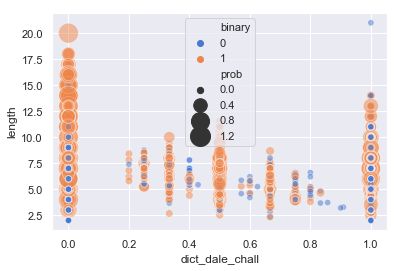

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

#Select wikipedia train set of concatenation
data = concat_features[2].train
#data = data.loc[data.cal_ngram_2_sim_min<0.3,]

complexity_plot = sns.scatterplot(x="dict_dale_chall", y="length", hue="binary", size='prob',
            sizes=(40, 400), alpha=.5, palette="muted",
            data=data)
plt.show(complexity_plot)

In [172]:
complexity_plot_figure = complexity_plot.get_figure()
complexity_plot_figure.savefig('../plots/features/len-to-dale-chall.pdf')

# Feature Importance
Here we compute individual feature importance based on different metrics. For example, we implement and compute the F-Score, providing an idea of the discrimination power the feature has.

In [30]:
from collections import namedtuple
Result = namedtuple('Result', 'dataset, fc, agg, measure')
Dataset = namedtuple('Dataset', 'name, train, test')
FeatureDataset = namedtuple('FeatureDataset', 'name, fc, train, test')
FeatureCategory = namedtuple('FeatureCategory', 'name, func')
Feature = namedtuple('Feature', 'name, fc_name, train, test')
Metric = namedtuple('Metric', ('name, func'))

### (1) Utility Functions

In [106]:
def remove_labels_for_binary_df(dataframe):
    df = dataframe.copy()
    df = df.drop(['id', 'sentence', 'target', 'nat', 'non_nat', 
                  'nat_marked', 'non_nat_marked', 'prob', 'start', 
                  'end', 'p_target', 'lemma', 'p_lemma', 'pos_tag'], axis = 1)
    return df

def remove_labels_for_regr_df(dataframe):
    df = dataframe.copy()
    df = df.drop(['id', 'sentence', 'target', 'nat', 'non_nat', 
                  'nat_marked', 'non_nat_marked', 'binary', 'start', 
                  'end', 'p_target', 'lemma', 'p_lemma', 'pos_tag'], axis = 1)
    return df
    
def transform_feat_to_num(train, test):
    train_copy = train.copy()
    test_copy = test.copy()
    train_copy = train_copy.replace(np.inf, 0)
    train_copy = train_copy.replace(np.nan, 0)
    test_copy = test_copy.replace(np.inf, 0)
    test_copy = test_copy.replace(np.nan, 0)
    shape_train = train.shape
    shape_test = test.shape
    df = train_copy.append(test_copy, ignore_index=True)
    df = pd.get_dummies(df)
    return (df.loc[0:(shape_train[0]-1),], 
            df.loc[shape_train[0]:df.shape[0],])

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.dummy import DummyClassifier

def get_majority_class_prediction(train, test):
    dummy = DummyClassifier(strategy='most_frequent', 
                            random_state=None, constant=None)
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test
    y_test = test.binary.values
    dummy.fit(x_train, y_train)
    prediction = dummy.predict(x_test)
    f1score = f1_score(y_test, prediction)
    return f1score

def always_complex_prediction(train, test):
    y_test = test.binary.values
    prediction = [1 for val in y_test]
    f1score = f1_score(y_test, prediction)
    return f1score

def svm(train, test):
    print('average_classification')
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    seed = 7
    #knn = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
     #  beta_1=0.9, beta_2=0.999, early_stopping=False,
    #   epsilon=1e-08, hidden_layer_sizes=(5, 100), learning_rate='constant',
    #   learning_rate_init=0.001, max_iter=200, momentum=0.9,
    #   nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
    #   solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
    #   warm_start=False)
    knn = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    knn.fit(x_train, y_train) 
    prediction = knn.predict(x_test)
    f1score = f1_score(y_test, prediction)
    #kfold = model_selection.KFold(n_splits=2, random_state=seed)
    #cv_results = model_selection.cross_val_score(knn, x_train, y_train, cv=kfold, scoring=make_scorer(f1_score))
    return f1score

def xgboost(train, test):
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    xgtrain = xgb.DMatrix(x_train.values, label=y_train)
    xgtest = xgb.DMatrix(x_test.values, label=y_test)
    xg_test_x = xgb.DMatrix(x_test.values)
    param = {'max_depth': 30, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic',  'n_estimators':5000}
    evallist = [(xgtest, 'eval'), (xgtrain, 'train')]
    num_round = 70
    bst = xgb.train(param, xgtrain, num_round, evallist)
    prediction = bst.predict(xg_test_x)
    prediction_binary = list(map(lambda val: 1 if val>0.5 else 0, prediction))
    f1score = f1_score(y_test, prediction_binary)
    return f1score

def adaboost(train, test):
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    adab = AdaBoostClassifier(base_estimator=None, n_estimators=5000, 
                          learning_rate=1.0, algorithm='SAMME.R',
                          random_state=None)
    adab.fit(x_train, y_train) 
    prediction = adab.predict(x_test)
    f1score = f1_score(y_test, prediction)
    return f1score

C:\Users\Studio\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [268]:
dataset_concatenation = concat_feature_datasets(dataset_fc_semantic, dataset_fc_baseline_2, 
                                                dataset_fc_orthographic, dataset_fc_linguistic)

NameError: name 'dataset_fc_semantic' is not defined

In [267]:
dataset_concatenation[2].train

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,...,mrc_meanc,concreteness,dbp_entity_ratio_25,dbp_entity_support_25,dbp_type_hierachy_depth_25,dbp_freq_types_25,dbp_confidence,dbp_pagerank,dbp_norm_pagerank,dbp_type
0,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",4,10,barren,10,10,6,2,1,...,400.000000,3.200000,1.000000,1428.0,1.0,2.0,0.25,44.659900,0.004036,Misc
1,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",4,18,barren islands,10,10,0,1,1,...,400.000000,2.850000,0.928571,12164.5,0.5,1.5,0.25,124.742450,0.011272,Misc
2,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",20,25,reefs,10,10,1,2,1,...,400.000000,2.500000,1.000000,2968.0,0.0,1.0,0.25,63.847900,0.005770,DBpedia:notype
3,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",11,18,islands,10,10,0,0,0,...,400.000000,2.500000,1.000000,22901.0,0.0,1.0,0.25,204.825000,0.018509,DBpedia:notype
4,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",30,35,coral,10,10,0,0,0,...,337.000000,4.400000,1.000000,5112.0,3.0,5.0,0.75,127.051000,0.011481,Misc
5,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",30,44,coral outcrops,10,10,2,0,1,...,368.500000,3.450000,0.928571,2941.0,1.5,3.0,0.75,74.336200,0.006717,Misc
6,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",36,44,outcrops,10,10,5,6,1,...,400.000000,2.500000,1.000000,770.0,0.0,1.0,0.25,21.621400,0.001954,DBpedia:notype
7,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",95,106,overlapping,10,10,4,4,1,...,400.000000,3.270000,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,DBpedia:notype
8,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",49,57,believed,10,10,0,0,0,...,400.000000,2.500000,1.000000,2245.0,0.0,1.0,0.25,62.830500,0.005678,DBpedia:notype
9,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",67,71,rich,10,10,0,0,0,...,503.000000,2.790000,1.000000,6124.0,0.0,1.0,0.25,232.716000,0.021029,DBpedia:notype


In [58]:
results = [Result(fs.name, fs.fc, fs.agg,
    xgboost(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test)))) for fs in dataset_fc_baseline_1]

[0]	eval-error:0.29683	train-error:0.167718
[1]	eval-error:0.289625	train-error:0.147901
[2]	eval-error:0.286744	train-error:0.127184
[3]	eval-error:0.285303	train-error:0.117997
[4]	eval-error:0.283862	train-error:0.10953
[5]	eval-error:0.286744	train-error:0.102504
[6]	eval-error:0.285303	train-error:0.09746
[7]	eval-error:0.286744	train-error:0.093677
[8]	eval-error:0.283862	train-error:0.089353
[9]	eval-error:0.286744	train-error:0.08521
[10]	eval-error:0.279539	train-error:0.084309
[11]	eval-error:0.285303	train-error:0.082688
[12]	eval-error:0.286744	train-error:0.079625
[13]	eval-error:0.291066	train-error:0.077103
[14]	eval-error:0.291066	train-error:0.075662
[15]	eval-error:0.291066	train-error:0.0735
[16]	eval-error:0.288184	train-error:0.070438
[17]	eval-error:0.292507	train-error:0.070258
[18]	eval-error:0.291066	train-error:0.066655
[19]	eval-error:0.288184	train-error:0.067015
[20]	eval-error:0.289625	train-error:0.065394
[21]	eval-error:0.289625	train-error:0.065574
[22]

[40]	eval-error:0.295389	train-error:0.078725
[41]	eval-error:0.29683	train-error:0.078725
[42]	eval-error:0.295389	train-error:0.078364
[43]	eval-error:0.293948	train-error:0.078364
[44]	eval-error:0.302594	train-error:0.078364
[45]	eval-error:0.299712	train-error:0.078364
[46]	eval-error:0.304035	train-error:0.078364
[47]	eval-error:0.305476	train-error:0.078364
[48]	eval-error:0.302594	train-error:0.078364
[49]	eval-error:0.302594	train-error:0.078364
[50]	eval-error:0.299712	train-error:0.078364
[51]	eval-error:0.302594	train-error:0.078364
[52]	eval-error:0.29683	train-error:0.078364
[53]	eval-error:0.299712	train-error:0.078364
[54]	eval-error:0.299712	train-error:0.078364
[55]	eval-error:0.299712	train-error:0.078364
[56]	eval-error:0.29683	train-error:0.078364
[57]	eval-error:0.302594	train-error:0.078364
[58]	eval-error:0.305476	train-error:0.078364
[59]	eval-error:0.302594	train-error:0.078364
[60]	eval-error:0.293948	train-error:0.078364
[61]	eval-error:0.293948	train-error:

[10]	eval-error:0.236782	train-error:0.089595
[11]	eval-error:0.23908	train-error:0.088304
[12]	eval-error:0.23908	train-error:0.086625
[13]	eval-error:0.241379	train-error:0.084818
[14]	eval-error:0.23908	train-error:0.083011
[15]	eval-error:0.23908	train-error:0.082494
[16]	eval-error:0.23908	train-error:0.08159
[17]	eval-error:0.236782	train-error:0.081332
[18]	eval-error:0.237931	train-error:0.080687
[19]	eval-error:0.235632	train-error:0.077718
[20]	eval-error:0.236782	train-error:0.07733
[21]	eval-error:0.234483	train-error:0.076556
[22]	eval-error:0.233333	train-error:0.076685
[23]	eval-error:0.232184	train-error:0.074748
[24]	eval-error:0.233333	train-error:0.074232
[25]	eval-error:0.231034	train-error:0.074103
[26]	eval-error:0.233333	train-error:0.073715
[27]	eval-error:0.232184	train-error:0.071779
[28]	eval-error:0.233333	train-error:0.070617
[29]	eval-error:0.233333	train-error:0.07023
[30]	eval-error:0.232184	train-error:0.069584
[31]	eval-error:0.231034	train-error:0.069

[50]	eval-error:0.24023	train-error:0.091273
[51]	eval-error:0.23908	train-error:0.091273
[52]	eval-error:0.237931	train-error:0.091273
[53]	eval-error:0.23908	train-error:0.091273
[54]	eval-error:0.23908	train-error:0.091273
[55]	eval-error:0.236782	train-error:0.091273
[56]	eval-error:0.24023	train-error:0.091273
[57]	eval-error:0.241379	train-error:0.091273
[58]	eval-error:0.24023	train-error:0.091273
[59]	eval-error:0.23908	train-error:0.091273
[60]	eval-error:0.237931	train-error:0.091273
[61]	eval-error:0.236782	train-error:0.091273
[62]	eval-error:0.237931	train-error:0.091273
[63]	eval-error:0.24023	train-error:0.091273
[64]	eval-error:0.24023	train-error:0.091273
[65]	eval-error:0.242529	train-error:0.091273
[66]	eval-error:0.241379	train-error:0.091273
[67]	eval-error:0.243678	train-error:0.091273
[68]	eval-error:0.242529	train-error:0.091273
[69]	eval-error:0.241379	train-error:0.091273
[0]	eval-error:0.245977	train-error:0.161245
[1]	eval-error:0.23908	train-error:0.144849


[20]	eval-error:0.174603	train-error:0.075489
[21]	eval-error:0.174603	train-error:0.075489
[22]	eval-error:0.177438	train-error:0.074918
[23]	eval-error:0.180272	train-error:0.074347
[24]	eval-error:0.179138	train-error:0.074275
[25]	eval-error:0.179138	train-error:0.074275
[26]	eval-error:0.175737	train-error:0.073204
[27]	eval-error:0.178571	train-error:0.072775
[28]	eval-error:0.179705	train-error:0.07199
[29]	eval-error:0.178005	train-error:0.071418
[30]	eval-error:0.178005	train-error:0.071418
[31]	eval-error:0.178005	train-error:0.071418
[32]	eval-error:0.176304	train-error:0.07149
[33]	eval-error:0.172902	train-error:0.07049
[34]	eval-error:0.174603	train-error:0.069919
[35]	eval-error:0.17517	train-error:0.069847
[36]	eval-error:0.175737	train-error:0.06949
[37]	eval-error:0.176304	train-error:0.069347
[38]	eval-error:0.174603	train-error:0.069276
[39]	eval-error:0.17517	train-error:0.069276
[40]	eval-error:0.175737	train-error:0.069204
[41]	eval-error:0.174603	train-error:0.0

[60]	eval-error:0.185941	train-error:0.100557
[61]	eval-error:0.187642	train-error:0.100557
[62]	eval-error:0.184807	train-error:0.100557
[63]	eval-error:0.184807	train-error:0.100557
[64]	eval-error:0.18424	train-error:0.100557
[65]	eval-error:0.184807	train-error:0.100557
[66]	eval-error:0.186508	train-error:0.100557
[67]	eval-error:0.186508	train-error:0.100486
[68]	eval-error:0.18424	train-error:0.100486
[69]	eval-error:0.184807	train-error:0.100486
[0]	eval-error:0.193311	train-error:0.135623
[1]	eval-error:0.199546	train-error:0.124268
[2]	eval-error:0.202381	train-error:0.116769
[3]	eval-error:0.193878	train-error:0.109342
[4]	eval-error:0.193311	train-error:0.105842
[5]	eval-error:0.192177	train-error:0.105199
[6]	eval-error:0.193311	train-error:0.1032
[7]	eval-error:0.189909	train-error:0.099771
[8]	eval-error:0.186508	train-error:0.097843
[9]	eval-error:0.184807	train-error:0.097129
[10]	eval-error:0.183673	train-error:0.096629
[11]	eval-error:0.185941	train-error:0.096558
[1

In [60]:
evaluation = [{'dataset' : result.dataset, 'agg' : result.agg.name,
                    'fc' : result.fc.name, 'f1-score' : result.measure} 
                   for result in results]
feature_eval_data = pd.DataFrame.from_records(evaluation)
feature_eval_data

,agg,dataset,f1-score,fc
0,mean,Wikipedia,0.693098,baseline_1
1,median,Wikipedia,0.688235,baseline_1
2,max,Wikipedia,0.698507,baseline_1
3,min,Wikipedia,0.655589,baseline_1
4,weighted_mean,Wikipedia,0.700880,baseline_1
5,mean,WikiNews,0.715673,baseline_1
6,median,WikiNews,0.705394,baseline_1
7,max,WikiNews,0.705882,baseline_1
8,min,WikiNews,0.698592,baseline_1
9,weighted_mean,WikiNews,0.711485,baseline_1


### Baseline Prediction : Majority Class

In [17]:
[remove_labels_for_binary_df(ds.test) for ds in datasets]

[     binary
 0         1
 1         1
 2         1
 3         1
 4         1
 5         0
 6         1
 7         0
 8         1
 9         0
 10        1
 11        1
 12        1
 13        1
 14        0
 15        0
 16        1
 17        0
 18        1
 19        0
 20        0
 21        0
 22        0
 23        0
 24        1
 25        1
 26        1
 27        1
 28        1
 29        1
 ..      ...
 664       1
 665       0
 666       1
 667       1
 668       1
 669       1
 670       0
 671       1
 672       1
 673       1
 674       0
 675       0
 676       1
 677       1
 678       1
 679       0
 680       1
 681       1
 682       1
 683       0
 684       0
 685       0
 686       0
 687       1
 688       1
 689       1
 690       0
 691       0
 692       1
 693       1
 
 [694 rows x 1 columns],      binary
 0         1
 1         1
 2         1
 3         1
 4         1
 5         1
 6         1
 7         0
 8         0
 9         1
 10        0
 11        1

In [27]:
from collections import Counter

counter = Counter(datasets[2].train.binary)
counter

Counter({0: 8459, 1: 5543})

### (x) Baseline Always Complex

In [32]:
from collections import Counter

results = [Result(ds.name, 'always_complex', 
    always_complex_prediction(remove_labels_for_binary_df(ds.train), 
        remove_labels_for_binary_df(ds.test))) for ds in datasets]
evaluation = [{'dataset' : result.dataset, 
                    'fc' : result.fc, 'f1-score' : result.measure} 
                   for result in results]
counts = [(ds.name, Counter(ds.test.binary)) for ds in datasets]
feature_eval_data = pd.DataFrame.from_records(evaluation)
print(counts)
print(feature_eval_data)

[('Wikipedia', Counter({0: 355, 1: 339})), ('WikiNews', Counter({0: 517, 1: 353})), ('News', Counter({0: 1068, 1: 696}))]
     dataset  f1-score              fc
0  Wikipedia  0.656341  always_complex
1   WikiNews  0.577269  always_complex
2       News  0.565854  always_complex


### (x) Baseline Memorize Vocabulary

In [80]:
# What about lowercasing the words and stripping?

def build_vocabulary(train):
    targets_complex = set([mwe for mwe in train.loc[train['binary'] == 1,]['target'].tolist()])
    targets_non_complex = set([mwe for mwe in train.loc[train['binary'] == 0,]['target'].tolist()])
    targets_complex_cleaned = list(targets_complex.difference(targets_non_complex))
    targets_non_complex_cleaned = list(targets_non_complex.difference(targets_complex))
    vocabulary = {}
    for target in targets_complex_cleaned:
        vocabulary[target] = 1
    for target in targets_non_complex_cleaned:
        vocabulary[target] = 0
    return vocabulary

def evaluate_label_target_predictions(test, vocabulary):
    dict_test = dict(zip(test.target, test.binary))
    data = [(binary, (vocabulary[target] if target in vocabulary else 1)) 
            for target, binary in dict_test.items()]
    y_true = [vals[0] for vals in data]
    prediction = [vals[1] for vals in data]
    return f1_score(y_true, prediction)

evaluation = [(evaluate_label_target_predictions(ds.test, 
                    build_vocabulary(ds.train)), ds.name) for ds in datasets]
evaluation

[(0.7402597402597403, 'Wikipedia'),
 (0.7398273736128236, 'WikiNews'),
 (0.7812274368231046, 'News')]

### (2) Feature Category Analysis

In [114]:
all_fc_datasets = []
all_fc_datasets.extend(dataset_fc_baseline_1)
all_fc_datasets.extend(dataset_fc_baseline_2)
#all_fc_datasets.extend(dataset_fc_orthographic)
#all_fc_datasets.extend(dataset_fc_linguistic)
#all_fc_datasets.extend(dataset_fc_corpus_based)
#all_fc_datasets.extend(dataset_fc_psycholinguistic)
#all_fc_datasets.extend(dataset_fc_semantic)
#all_fc_datasets.extend(dataset_fc_dictionary)

In [115]:
results = [Result(fs.name, fs.fc, fs.agg,
    xgboost(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test)))) for fs in all_fc_datasets]

[0]	eval-error:0.29683	train-error:0.167718
[1]	eval-error:0.289625	train-error:0.147901
[2]	eval-error:0.286744	train-error:0.127184
[3]	eval-error:0.285303	train-error:0.117997
[4]	eval-error:0.283862	train-error:0.10953
[5]	eval-error:0.286744	train-error:0.102504
[6]	eval-error:0.285303	train-error:0.09746
[7]	eval-error:0.286744	train-error:0.093677
[8]	eval-error:0.283862	train-error:0.089353
[9]	eval-error:0.286744	train-error:0.08521
[10]	eval-error:0.279539	train-error:0.084309
[11]	eval-error:0.285303	train-error:0.082688
[12]	eval-error:0.286744	train-error:0.079625
[13]	eval-error:0.291066	train-error:0.077103
[14]	eval-error:0.291066	train-error:0.075662
[15]	eval-error:0.291066	train-error:0.0735
[16]	eval-error:0.288184	train-error:0.070438
[17]	eval-error:0.292507	train-error:0.070258
[18]	eval-error:0.291066	train-error:0.066655
[19]	eval-error:0.288184	train-error:0.067015
[20]	eval-error:0.289625	train-error:0.065394
[21]	eval-error:0.289625	train-error:0.065574
[22]

[40]	eval-error:0.295389	train-error:0.078725
[41]	eval-error:0.29683	train-error:0.078725
[42]	eval-error:0.295389	train-error:0.078364
[43]	eval-error:0.293948	train-error:0.078364
[44]	eval-error:0.302594	train-error:0.078364
[45]	eval-error:0.299712	train-error:0.078364
[46]	eval-error:0.304035	train-error:0.078364
[47]	eval-error:0.305476	train-error:0.078364
[48]	eval-error:0.302594	train-error:0.078364
[49]	eval-error:0.302594	train-error:0.078364
[50]	eval-error:0.299712	train-error:0.078364
[51]	eval-error:0.302594	train-error:0.078364
[52]	eval-error:0.29683	train-error:0.078364
[53]	eval-error:0.299712	train-error:0.078364
[54]	eval-error:0.299712	train-error:0.078364
[55]	eval-error:0.299712	train-error:0.078364
[56]	eval-error:0.29683	train-error:0.078364
[57]	eval-error:0.302594	train-error:0.078364
[58]	eval-error:0.305476	train-error:0.078364
[59]	eval-error:0.302594	train-error:0.078364
[60]	eval-error:0.293948	train-error:0.078364
[61]	eval-error:0.293948	train-error:

[10]	eval-error:0.236782	train-error:0.089595
[11]	eval-error:0.23908	train-error:0.088304
[12]	eval-error:0.23908	train-error:0.086625
[13]	eval-error:0.241379	train-error:0.084818
[14]	eval-error:0.23908	train-error:0.083011
[15]	eval-error:0.23908	train-error:0.082494
[16]	eval-error:0.23908	train-error:0.08159
[17]	eval-error:0.236782	train-error:0.081332
[18]	eval-error:0.237931	train-error:0.080687
[19]	eval-error:0.235632	train-error:0.077718
[20]	eval-error:0.236782	train-error:0.07733
[21]	eval-error:0.234483	train-error:0.076556
[22]	eval-error:0.233333	train-error:0.076685
[23]	eval-error:0.232184	train-error:0.074748
[24]	eval-error:0.233333	train-error:0.074232
[25]	eval-error:0.231034	train-error:0.074103
[26]	eval-error:0.233333	train-error:0.073715
[27]	eval-error:0.232184	train-error:0.071779
[28]	eval-error:0.233333	train-error:0.070617
[29]	eval-error:0.233333	train-error:0.07023
[30]	eval-error:0.232184	train-error:0.069584
[31]	eval-error:0.231034	train-error:0.069

[50]	eval-error:0.24023	train-error:0.091273
[51]	eval-error:0.23908	train-error:0.091273
[52]	eval-error:0.237931	train-error:0.091273
[53]	eval-error:0.23908	train-error:0.091273
[54]	eval-error:0.23908	train-error:0.091273
[55]	eval-error:0.236782	train-error:0.091273
[56]	eval-error:0.24023	train-error:0.091273
[57]	eval-error:0.241379	train-error:0.091273
[58]	eval-error:0.24023	train-error:0.091273
[59]	eval-error:0.23908	train-error:0.091273
[60]	eval-error:0.237931	train-error:0.091273
[61]	eval-error:0.236782	train-error:0.091273
[62]	eval-error:0.237931	train-error:0.091273
[63]	eval-error:0.24023	train-error:0.091273
[64]	eval-error:0.24023	train-error:0.091273
[65]	eval-error:0.242529	train-error:0.091273
[66]	eval-error:0.241379	train-error:0.091273
[67]	eval-error:0.243678	train-error:0.091273
[68]	eval-error:0.242529	train-error:0.091273
[69]	eval-error:0.241379	train-error:0.091273
[0]	eval-error:0.245977	train-error:0.161245
[1]	eval-error:0.23908	train-error:0.144849


[20]	eval-error:0.174603	train-error:0.075489
[21]	eval-error:0.174603	train-error:0.075489
[22]	eval-error:0.177438	train-error:0.074918
[23]	eval-error:0.180272	train-error:0.074347
[24]	eval-error:0.179138	train-error:0.074275
[25]	eval-error:0.179138	train-error:0.074275
[26]	eval-error:0.175737	train-error:0.073204
[27]	eval-error:0.178571	train-error:0.072775
[28]	eval-error:0.179705	train-error:0.07199
[29]	eval-error:0.178005	train-error:0.071418
[30]	eval-error:0.178005	train-error:0.071418
[31]	eval-error:0.178005	train-error:0.071418
[32]	eval-error:0.176304	train-error:0.07149
[33]	eval-error:0.172902	train-error:0.07049
[34]	eval-error:0.174603	train-error:0.069919
[35]	eval-error:0.17517	train-error:0.069847
[36]	eval-error:0.175737	train-error:0.06949
[37]	eval-error:0.176304	train-error:0.069347
[38]	eval-error:0.174603	train-error:0.069276
[39]	eval-error:0.17517	train-error:0.069276
[40]	eval-error:0.175737	train-error:0.069204
[41]	eval-error:0.174603	train-error:0.0

[60]	eval-error:0.185941	train-error:0.100557
[61]	eval-error:0.187642	train-error:0.100557
[62]	eval-error:0.184807	train-error:0.100557
[63]	eval-error:0.184807	train-error:0.100557
[64]	eval-error:0.18424	train-error:0.100557
[65]	eval-error:0.184807	train-error:0.100557
[66]	eval-error:0.186508	train-error:0.100557
[67]	eval-error:0.186508	train-error:0.100486
[68]	eval-error:0.18424	train-error:0.100486
[69]	eval-error:0.184807	train-error:0.100486
[0]	eval-error:0.193311	train-error:0.135623
[1]	eval-error:0.199546	train-error:0.124268
[2]	eval-error:0.202381	train-error:0.116769
[3]	eval-error:0.193878	train-error:0.109342
[4]	eval-error:0.193311	train-error:0.105842
[5]	eval-error:0.192177	train-error:0.105199
[6]	eval-error:0.193311	train-error:0.1032
[7]	eval-error:0.189909	train-error:0.099771
[8]	eval-error:0.186508	train-error:0.097843
[9]	eval-error:0.184807	train-error:0.097129
[10]	eval-error:0.183673	train-error:0.096629
[11]	eval-error:0.185941	train-error:0.096558
[1

[30]	eval-error:0.28098	train-error:0.052063
[31]	eval-error:0.276657	train-error:0.052063
[32]	eval-error:0.275216	train-error:0.052063
[33]	eval-error:0.278098	train-error:0.052063
[34]	eval-error:0.278098	train-error:0.052063
[35]	eval-error:0.279539	train-error:0.052063
[36]	eval-error:0.28098	train-error:0.052063
[37]	eval-error:0.278098	train-error:0.052063
[38]	eval-error:0.275216	train-error:0.052063
[39]	eval-error:0.278098	train-error:0.052063
[40]	eval-error:0.279539	train-error:0.052063
[41]	eval-error:0.276657	train-error:0.052063
[42]	eval-error:0.273775	train-error:0.052063
[43]	eval-error:0.275216	train-error:0.052063
[44]	eval-error:0.273775	train-error:0.052063
[45]	eval-error:0.276657	train-error:0.052063
[46]	eval-error:0.278098	train-error:0.052063
[47]	eval-error:0.275216	train-error:0.052063
[48]	eval-error:0.276657	train-error:0.052063
[49]	eval-error:0.28098	train-error:0.052063
[50]	eval-error:0.276657	train-error:0.052063
[51]	eval-error:0.275216	train-error:

[0]	eval-error:0.331412	train-error:0.152225
[1]	eval-error:0.298271	train-error:0.127184
[2]	eval-error:0.311239	train-error:0.108089
[3]	eval-error:0.304035	train-error:0.095839
[4]	eval-error:0.298271	train-error:0.090434
[5]	eval-error:0.306916	train-error:0.08485
[6]	eval-error:0.308357	train-error:0.080886
[7]	eval-error:0.301153	train-error:0.078725
[8]	eval-error:0.29683	train-error:0.075842
[9]	eval-error:0.295389	train-error:0.072059
[10]	eval-error:0.292507	train-error:0.070438
[11]	eval-error:0.295389	train-error:0.068997
[12]	eval-error:0.286744	train-error:0.068096
[13]	eval-error:0.285303	train-error:0.066655
[14]	eval-error:0.288184	train-error:0.066114
[15]	eval-error:0.288184	train-error:0.066294
[16]	eval-error:0.288184	train-error:0.065934
[17]	eval-error:0.283862	train-error:0.065754
[18]	eval-error:0.283862	train-error:0.065394
[19]	eval-error:0.288184	train-error:0.065033
[20]	eval-error:0.289625	train-error:0.064313
[21]	eval-error:0.288184	train-error:0.064313


[40]	eval-error:0.204598	train-error:0.065324
[41]	eval-error:0.201149	train-error:0.065324
[42]	eval-error:0.2	train-error:0.065324
[43]	eval-error:0.205747	train-error:0.065324
[44]	eval-error:0.205747	train-error:0.065324
[45]	eval-error:0.202299	train-error:0.065324
[46]	eval-error:0.206897	train-error:0.065324
[47]	eval-error:0.203448	train-error:0.065324
[48]	eval-error:0.204598	train-error:0.065324
[49]	eval-error:0.205747	train-error:0.065324
[50]	eval-error:0.203448	train-error:0.065324
[51]	eval-error:0.204598	train-error:0.065324
[52]	eval-error:0.206897	train-error:0.065324
[53]	eval-error:0.202299	train-error:0.065324
[54]	eval-error:0.203448	train-error:0.065324
[55]	eval-error:0.204598	train-error:0.065324
[56]	eval-error:0.202299	train-error:0.065324
[57]	eval-error:0.204598	train-error:0.065324
[58]	eval-error:0.204598	train-error:0.065324
[59]	eval-error:0.203448	train-error:0.065324
[60]	eval-error:0.202299	train-error:0.065324
[61]	eval-error:0.204598	train-error:0.

[10]	eval-error:0.198851	train-error:0.081332
[11]	eval-error:0.2	train-error:0.080945
[12]	eval-error:0.206897	train-error:0.080945
[13]	eval-error:0.198851	train-error:0.079912
[14]	eval-error:0.2	train-error:0.078492
[15]	eval-error:0.203448	train-error:0.078492
[16]	eval-error:0.202299	train-error:0.077588
[17]	eval-error:0.203448	train-error:0.077459
[18]	eval-error:0.198851	train-error:0.076943
[19]	eval-error:0.202299	train-error:0.076039
[20]	eval-error:0.201149	train-error:0.075781
[21]	eval-error:0.201149	train-error:0.075136
[22]	eval-error:0.203448	train-error:0.075265
[23]	eval-error:0.201149	train-error:0.075265
[24]	eval-error:0.202299	train-error:0.075136
[25]	eval-error:0.202299	train-error:0.074877
[26]	eval-error:0.201149	train-error:0.074877
[27]	eval-error:0.201149	train-error:0.074877
[28]	eval-error:0.203448	train-error:0.074619
[29]	eval-error:0.201149	train-error:0.074619
[30]	eval-error:0.203448	train-error:0.074748
[31]	eval-error:0.203448	train-error:0.07461

[52]	eval-error:0.164399	train-error:0.065991
[53]	eval-error:0.164966	train-error:0.065991
[54]	eval-error:0.163832	train-error:0.065991
[55]	eval-error:0.163832	train-error:0.065991
[56]	eval-error:0.164399	train-error:0.065991
[57]	eval-error:0.163832	train-error:0.065991
[58]	eval-error:0.161565	train-error:0.065991
[59]	eval-error:0.160431	train-error:0.065991
[60]	eval-error:0.160431	train-error:0.065991
[61]	eval-error:0.162698	train-error:0.065991
[62]	eval-error:0.162132	train-error:0.065991
[63]	eval-error:0.164399	train-error:0.065991
[64]	eval-error:0.160998	train-error:0.065991
[65]	eval-error:0.160998	train-error:0.065991
[66]	eval-error:0.161565	train-error:0.065991
[67]	eval-error:0.162698	train-error:0.065991
[68]	eval-error:0.160998	train-error:0.065991
[69]	eval-error:0.163832	train-error:0.065991
[0]	eval-error:0.176871	train-error:0.121625
[1]	eval-error:0.171202	train-error:0.107128
[2]	eval-error:0.162698	train-error:0.095415
[3]	eval-error:0.157596	train-error:0

[23]	eval-error:0.166667	train-error:0.072847
[24]	eval-error:0.166667	train-error:0.072847
[25]	eval-error:0.166667	train-error:0.072847
[26]	eval-error:0.167234	train-error:0.072775
[27]	eval-error:0.1678	train-error:0.072704
[28]	eval-error:0.1661	train-error:0.072632
[29]	eval-error:0.160998	train-error:0.072632
[30]	eval-error:0.159297	train-error:0.072632
[31]	eval-error:0.159297	train-error:0.072632
[32]	eval-error:0.164966	train-error:0.072632
[33]	eval-error:0.161565	train-error:0.072632
[34]	eval-error:0.161565	train-error:0.072632
[35]	eval-error:0.160998	train-error:0.072632
[36]	eval-error:0.162132	train-error:0.072632
[37]	eval-error:0.164399	train-error:0.072632
[38]	eval-error:0.15873	train-error:0.072632
[39]	eval-error:0.158163	train-error:0.072632
[40]	eval-error:0.158163	train-error:0.072632
[41]	eval-error:0.160431	train-error:0.072632
[42]	eval-error:0.160998	train-error:0.072632
[43]	eval-error:0.162698	train-error:0.072632
[44]	eval-error:0.162698	train-error:0.

In [116]:
evaluation = [{'dataset' : result.dataset, 'agg' : result.agg.name,
                    'fc' : result.fc.name, 'f1-score' : result.measure} 
                   for result in results]
feature_eval_data = pd.DataFrame.from_records(evaluation)

In [117]:
feature_eval_data

,agg,dataset,f1-score,fc
0,mean,Wikipedia,0.693098,baseline_1
1,median,Wikipedia,0.688235,baseline_1
2,max,Wikipedia,0.698507,baseline_1
3,min,Wikipedia,0.655589,baseline_1
4,weighted_mean,Wikipedia,0.700880,baseline_1
5,mean,WikiNews,0.715673,baseline_1
6,median,WikiNews,0.705394,baseline_1
7,max,WikiNews,0.705882,baseline_1
8,min,WikiNews,0.698592,baseline_1
9,weighted_mean,WikiNews,0.711485,baseline_1


In [243]:
dataset_semantic_linguistic = concat_feature_datasets(dataset_fc_baseline_2)

NameError: name 'concat_feature_datasets' is not defined

In [283]:
results = [Result(fs.name, fs.fc, 
    average_classification_f1(*transform_feat_to_num(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test)))) for fs in dataset_semantic_linguistic]

evaluation = [{'dataset' : result.dataset, 
                    'fc' : result.fc, 'f1-score' : result.measure} 
                   for result in results]
feature_eval_data = pd.DataFrame.from_records(evaluation)

average_classification
average_classification
average_classification


In [284]:
feature_eval_data

,dataset,f1-score,fc
0,Wikipedia,0.742857,"[(baseline_2, <function features_baseline_2 at..."
1,WikiNews,0.730310,"[(baseline_2, <function features_baseline_2 at..."
2,News,0.800794,"[(baseline_2, <function features_baseline_2 at..."


### (2) Feature Importance Metrics

In [57]:
from sklearn.model_selection import permutation_test_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import matthews_corrcoef

def metric_fi_f_score(train, test, feat_name):
    df = train.copy()
    mean_feat = np.mean(df.loc[:, [feat_name]].values)
    means = df.loc[: , [feat_name, 'binary']].groupby('binary').mean().reset_index()
    mean_negativ = means.loc[means['binary'] == 0, [feat_name]][feat_name][0]
    mean_positiv = means.loc[means['binary'] == 1, [feat_name]][feat_name][1]
    # Compute the sum of deviations of the class mean from the overall mean
    class_mean_devs = (mean_positiv - mean_feat)**2 + (mean_negativ - mean_feat)**2
    # Compute neagtive instance based values
    neg_inst = df.loc[df['binary'] == 0, [feat_name]].values
    std_dev_neg = (np.sum((neg_inst - mean_negativ)**2) / (len(neg_inst) - 1))
    #Compute positive instance based values
    pos_inst = df.loc[df['binary'] == 1, [feat_name]].values
    std_dev_pos = (np.sum((pos_inst - mean_positiv)**2) / (len(pos_inst) - 1))
    return class_mean_devs / (std_dev_neg + std_dev_pos)


def metric_fi_permutation_test(train, test, feat_name):
    svm = SVC(kernel='rbf', verbose=2)
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    score = permutation_test_score(svm, x_train.values, y_train, groups=None, cv=None, 
                        n_permutations=10, n_jobs=1, random_state=0, 
                        verbose=2, scoring=None)
    return score[2]


def metric_fi_classification_f1(train, test, label_name):
    print('average_classification')
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    seed = 7
    knn = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    #kfold = model_selection.KFold(n_splits=10, random_state=seed)
    #cv_results = model_selection.cross_val_score(knn, x_train, y_train, cv=kfold, scoring=make_scorer(f1_score))
    return f1_score(y_test, prediction, average=None)


def metric_fi_classification_mattcorr(train, test, label_name):
    print('average_classification')
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    seed = 7
    knn = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    #kfold = model_selection.KFold(n_splits=10, random_state=seed)
    #cv_results = model_selection.cross_val_score(knn, x_train, y_train, cv=kfold, scoring=make_scorer(f1_score))
    return matthews_corrcoef(y_test, prediction)

metric_fisher_score = Metric('f-score', metric_fi_f_score)
metric_permutation_test = Metric('f-score', metric_fi_permutation_test)
metric_classification_f1 = Metric('f-score', metric_fi_classification_f1)
metric_classification_mattcor = Metric('f-score', metric_fi_classification_mattcorr)

In [16]:
datasets = dataset_fc_orthographic

In [20]:
results = [Result(fs.name, fs.fc, 
    average_classification_f1(remove_labels_for_binary_df(fs.train), 
        remove_labels_for_binary_df(fs.test))) for fs in datasets]

average_classification
average_classification
average_classification


In [21]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

feature_eval_data = [{'dataset' : result.dataset, 
                    'fc' : result.fc.name, 'f1-score' : result.measure[0]} 
                   for result in results]
feature_eval_data = pd.DataFrame.from_records(feature_eval_data)

#dim_plot = sns.lineplot(x="dimension", y="f1-score",
#             hue="dataset", style="dataset", err_style = 'band',
#             data=dimensions_data)
#print(dimensions_data)
#plt.show(dim_plot)
feature_eval_data

,dataset,f1-score,fc
0,Wikipedia,0.704065,orthographic
1,WikiNews,0.700285,orthographic
2,News,0.639290,orthographic


# Misc

In [ ]:
pd.options.display.max_colwidth = 200
df_trans = df.loc[df.length < 5, ["sentence", "target", "binary"]]
df_trans.loc[df_trans.binary == 1]

In [ ]:
group = df.loc[:,['target', 'binary']].groupby(['target'], as_index=False)
grouped = group.filter(lambda x : (x['binary'].mean() > 0) & (x['binary'].mean() < 1))
targets = grouped['target'].unique()
targets

In [ ]:
df.loc[df['target'] == 'major',['target', 'binary', 'id','sentence', 'ctx_length']]

In [ ]:
import requests
from lxml import html

page = requests.get('http://sentence.yourdictionary.com/decomposition')
tree = html.fromstring(page.content)
sentences = tree.xpath("//div[@class='li_content']/text()")

for sentence in sentences:
    print(sentence)

In [1]:
import requests
from lxml import html

page = requests.get('https://prowritingaid.com/en/Collocation/Dictionary?word=Coffee')
tree = html.fromstring(page.content)
sentences = tree.xpath("//a[@class='pwa-link']/text()")

for sentence in sentences:
    print(sentence)

table
cup
shop
mug
down
look
hand
two
back
like
machine
pot
front
sat
tea
get
make
took
down
over
pot
black
like
want
two
hot
will
made
back
went
table
cup
down
shop
get
took
over
pot
two
like
make
back
mug
will
look
black
made
hot
can
went
want
hand
room
sugar
put
morning
just
sat
front
after
cup
tea
table
pot
sugar
shop
house
cups
cocoa
houses
mug
cotton
morning
room
milk
cup
tea
sugar
shop
house
table
cocoa
pot
mug
tobacco
cotton
bread
room
plantation
juice
chocolate
morning
banana
milk
alcohol
fruit
bean
break
hand
breakfast
bacon
rubber
restaurant
rice
sandwich
be
sip
drink
have
make
take
will
bring
'll
set
order
's
sit
serve
get
want
pour
finish
can
brew
steam
go
come
put
offer
use
buy
meet
carry
do
much
empty
black
hot
second
More
such
first
long
strong
own
many
instant
half
good
low
third
fresh
local
endless
little
fourth
cold
hard
high
nice
decent
large
public
well
then
not
when
just
down
Just
only
together
much
too
now
very
daily
where
instead
there
late
back
away
maybe
here


In [ ]:
df.loc[df['sentence'].str.contains('although'),['target', 'sentence', 'binary']]

In [ ]:
df['ctx_length'] = df.sentence.apply(lambda sent : np.mean([len(t) for t in sent.split()]))
df['ctx_target_length_dev'] = df.length - df.ctx_length
df.loc[:,['target', 'length', 'ctx_length', 'ctx_target_length_dev', 'binary','sentence']]
grouped = df.loc[:,['sentence', 'binary', 'ctx_length']].groupby('sentence').agg(['sum']).eval('Col4 = Col2 / Col3')
grouped

In [ ]:
df.loc[(df['ctx_target_length_dev'] > 2) & (df['binary'] == 0),['id','target', 'sentence', 'binary', 'ctx_target_length_dev']]

In [ ]:
wordNetLemmatizer = WordNetLemmatizer()
print(wordNetLemmatizer.lemmatize("written", 'v'))

In [ ]:
from whoosh.index import create_in
from whoosh.fields import *
schema = Schema(title=TEXT(stored=True), path=ID(stored=True), content=TEXT)
ix = create_in("indexdir", schema)
writer = ix.writer()
writer.add_document(title=u"First document", path=u"/a", \
                    content=u"This is the first document we've added!")
writer.add_document(title=u"Second document", path=u"/b",\
                     content=u"The second one is even more interesting!")
writer.commit()
from whoosh.qparser import QueryParser
with ix.searcher() as searcher:
    query = QueryParser("content", ix.schema).parse("first")
    results = searcher.search(query)
    results[0]
        
{"title": u"First document", "path": u"/a"}

In [ ]:
df.loc[df['target'] == 'covered',['target', 'sentence', 'wn_synset_lesk_wsd__norm_sense_rank']]